# Beat the Books

#### A data science project by Jonathan Sears

### Project Plan
The main goal of this project is to find a way to profit of of sports betting. There are several reasons I want to do this. First I want to make money, I feel like that is pretty self explanatory. Additionally, sports books and casinos always stack the odds in their favor, so I think it would be cool to find a way to beat them at their own game. 

### The Plan
My approach to beat the books will be as follows:

1) Build a couple different machine learning models. One that given some data we can aquire before a game starts, predicts the winner of a game (moneyline), one that predicts the point differential (spread), and one that predicts the total number of points (over under). 
2) Scrape the odds from many different sportsbooks. Since sportsbooks operate independently, their odds are constantly changing. Exploting these discrepencies to get the best odds for any bet is essential if you want to beat the books. 
3) Using some math I'm going to calculate my predicted expected value for a given bet, if the expected value > 0, then I will classify it as a winning bet. Theoretically, if I place enough bets and my model is accurate, I should be able to beat the books. 

# Math

### Expected Value and the Law of Large Numbers
There is some important math we will need to have a strong understanding of during this project. The plus EV strategy relies on identifying bets with positive expected values, so it's important to have a strong understanding of what expected values are. The expected value of a bet will be:

    EV = P(event A happens)* (Payoff of event A) + P(event B) * (Payoff of event B)

When looking at this we can see how important it is to properly asses the probability of a given event happening is, as that's what will be the real difference between making and losing money.

The second important tool is the law of large numbers, which states that the more bets we place, the higher probability we have of reaching our expected value. This is important because while we might have a positive EV on a bet this doesn't guarantee that it will hit. What the law of large numbers is saying that if we place 1000 bets with 50% probability of hitting, then we have an incredibly high probability of hitting around 500 of them. Basically, the more bets we place, the closer we should get to converging to our expected value.  

### The Kelly Criterion
The Kelly Criterion is a simple mathematical formula we can use to size our bets:

f<sup>*</sup> = p - (1-p)/b 


**f<sup>*</sup>** is the fraction of our bankroll we should put on the bet

**p** is our estimated probability of winning

**b** is the proportion of the bet we stand to win (eg for 2:1 odds b =2)

# Data
The two datasets I found that I think will come in handy for this project are the 538 ELO model dataset and the spreadspoke historical odds dataset. Unfortunately I can't use the 538 ELO model as a predictor when building my own model, as it was discontinued before the 2023 NFL season. However, I think it could still be useful to compare it to my own model to get a gaugue of how well I'm doing. The spreadspoke dataset will likely be one of the most important finds for this whole project as historical odds, spreads, and over under lines will come in extremely handy when building my own model. Finding free data about the NFL turned out to be a lot harder than I thought. I couldn't find any datasets that had historical box scores or anything like that, so instead I decided to make my own by using webscraping. Lastly I needed to find a way to get current odds of NFL games from a wide range of sportsbooks. The Odds API came in extremely handy for this

**Data Sources:**
 
538 NFL ELO: https://github.com/fivethirtyeight/data/tree/master/nfl-elo

Spreadspoke: https://www.kaggle.com/datasets/tobycrabtree/nfl-scores-and-betting-data

Box scores scraped from: https://www.footballdb.com/games/

Odds API: https://the-odds-api.com/ 



Other potential sources:
@misc{gilani_sdvpy_2021,
  author = {Gilani, Saiem},
  title = {sportsdataverse-py: The SportsDataverse's Python Package for Sports Data.},
  url = {https://py.sportsdataverse.org},
  season = {2021}
}

NFL Data: https://pypi.org/project/nfl-data-py/

PFR webscraper: https://pypi.org/project/pro-football-reference-web-scraper/ 

League Average data by season from PFR: https://www.pro-football-reference.com/years/NFL/index.htm 

# ETL

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
from bs4 import BeautifulSoup
import re 
import json
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from random import randint
import seaborn as sns
import sportsdataverse.nfl as sdv_nfl
pd.set_option('display.max_columns',None)

In [35]:
#First lets read in our data
games = pd.read_csv('./Data/spreadspoke_scores.csv')
teams = pd.read_csv('./Data/nfl_teams.csv')
stadiums = pd.read_csv('./Data/nfl_stadiums.csv', encoding="unicode_escape")
past_elo = pd.read_csv('./Data/nfl_elo.csv')
recent_elo = pd.read_csv('./Data/nfl_elo_latest.csv')

In [36]:
#Let's also check our data types to make sure everything looks okay
games.dtypes
past_elo.dtypes
teams.dtypes
stadiums.dtypes

#lets change the neutral site from the elo stasets to a boolean type
past_elo['neutral'] = past_elo['neutral'].astype(bool)
recent_elo['neutral'] = recent_elo['neutral'].astype(bool)

#convert the date columns to datetime object
past_elo.loc[:,'date'] = pd.to_datetime(past_elo['date']).dt.floor('D')
recent_elo.loc[:,'date'] = pd.to_datetime(recent_elo['date']).dt.floor('D')
games.loc[:,'schedule_date'] = pd.to_datetime(games['schedule_date']).dt.floor('D')


In [37]:
# There's a lot of data in the elo datasets and a lot of it won't be useful for us. Lets drop all the data from before the superbowl era
sb_era_elo = past_elo[past_elo['season'] >= 1965]
#and lets add te recent games to this dataset as well
sb_era_elo = pd.concat([recent_elo,sb_era_elo])
#reindex the df
sb_era_elo = sb_era_elo.reindex(index=range(len(sb_era_elo)),copy=False)
#drop a random column that has all NaNs
sb_era_elo.dropna(subset = ['team1','team2','date','elo1_pre','elo2_pre'],inplace=True)

In [38]:
#Lets also drop games without betting data from the scores dataset
games.dropna(subset='spread_favorite', inplace=True)
games.dropna(subset='over_under_line', inplace=True)


In [39]:
games['schedule_date'] = pd.to_datetime(games['schedule_date'])


In [40]:
sb_era_elo['date'] = pd.to_datetime(sb_era_elo['date'])
sb_era_elo

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,qbelo1_pre,qbelo2_pre,qb1,qb2,qb1_value_pre,qb2_value_pre,qb1_adj,qb2_adj,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,quality,importance,total_rating
0,2022-09-08,2022.0,False,NaN,LAR,BUF,1614.761436,1614.246762,0.593181,0.406819,1576.964901,1652.043296,1582.712236,1613.252889,Matthew Stafford,Josh Allen,200.283690,259.606335,5.938708,9.144750,0.534145,0.465855,-47.502436,402.149420,175.505078,273.860644,1549.330347,1646.634779,10.0,31.0,91.0,59.0,75.0
1,2022-09-11,2022.0,False,NaN,MIA,NE,1539.979483,1537.002981,0.596597,0.403403,1560.633403,1516.349061,1518.380774,1513.692959,Tua Tagovailoa,Mac Jones,139.176472,143.536642,-0.538674,0.149008,0.582123,0.417877,179.561802,122.148555,143.215005,141.397833,1539.874207,1492.199526,20.0,7.0,56.0,85.0,71.0
2,2022-09-11,2022.0,False,NaN,CIN,PIT,1558.193285,1510.143510,0.657183,0.342817,1538.985268,1529.351527,1550.251126,1473.261200,Joe Burrow,Mitch Trubisky,173.650126,168.278069,3.742751,3.346756,0.675155,0.324845,23.319530,111.575433,158.617066,162.607806,1530.384153,1493.128173,20.0,23.0,56.0,75.0,66.0
3,2022-09-11,2022.0,False,NaN,ATL,NO,1436.671709,1543.815038,0.439647,0.560353,1430.691471,1549.795276,1379.244628,1516.085009,Marcus Mariota,Jameis Winston,111.532470,151.069226,-12.435739,3.305974,0.357017,0.642983,314.391296,151.832530,131.818353,151.145557,1374.515041,1520.814596,26.0,27.0,19.0,54.0,37.0
4,2022-09-11,2022.0,False,NaN,NYJ,BAL,1364.983381,1508.988219,0.388223,0.611777,1344.202019,1529.769581,1391.094637,1546.006711,Joe Flacco,Lamar Jackson,110.242373,162.712934,19.852514,-3.618196,0.384031,0.615969,116.176803,112.207146,110.835816,157.662356,1370.565348,1566.536000,9.0,24.0,34.0,51.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13994,2010-11-07,2010.0,False,NaN,MIN,ARI,1528.363000,1477.167000,0.661252,0.338748,1537.283000,1468.246000,1514.850004,1475.197706,Brett Favre,Derek Anderson,117.983546,22.853324,-19.749280,-28.076229,0.653543,0.346457,282.680804,2.429339,134.453272,20.810925,1524.297519,1465.750190,27.0,24.0,34.0,NaN,NaN
13995,2010-11-07,2010.0,False,NaN,CLE,NE,1446.799000,1642.252000,0.320615,0.679385,1490.775000,1598.276000,1418.583512,1628.761829,Colt McCoy,Tom Brady,67.290038,168.066088,13.955553,-2.526372,0.343110,0.656890,209.590139,204.939202,81.520048,171.753399,1461.653558,1585.691782,34.0,14.0,57.0,NaN,NaN
13996,2010-11-07,2010.0,False,NaN,OAK,KC,1465.160000,1479.977000,0.571721,0.428279,1476.770000,1468.367000,1479.273391,1491.111947,Jason Campbell,Matt Cassel,98.162059,93.100929,12.207309,8.181945,0.578842,0.421158,18.769775,117.098125,90.222831,95.500649,1490.791658,1479.593680,23.0,20.0,46.0,NaN,NaN
13997,2010-11-07,2010.0,False,NaN,DET,NYJ,1353.691000,1628.707000,0.229887,0.770113,1347.872000,1634.526000,1385.874228,1612.135744,Matthew Stafford,Mark Sanchez,82.837273,76.840705,-23.674661,-3.179248,0.253360,0.746640,239.306694,206.469888,98.484215,89.803623,1379.324850,1618.685123,20.0,23.0,36.0,NaN,NaN


Let's make some new columns indicating the winner of the game, who covered the spread, and if the over hit. 
For the over we will use 0 if the over did not hit, 1 if the over did hit, and 2 if the game was a push

In [41]:
def winner(df):
    if df['score_home'] > df['score_away']:
        return df['team_home']
    elif df['score_away'] > df['score_home']:
        return df['team_away']
    else:
        return 'Tie'
    
def over(df):
    if float(df['score_home'] + df['score_away']) > float(df['over_under_line']):
        return "Over"
    elif float(df['score_home'] + df['score_away']) < float(df['over_under_line']):
        return "Under"
    else:
        return "Push"
#Define functions to get the abbreviation for each team in the games dataset
def find_home_team_abbrev(df,):
    match = teams[teams['team_name'] == df['team_home']]
    abrev = match.iloc[0]['team_id']
    return abrev
def find_away_team_abbrev(df,):
    match = teams[teams['team_name'] == df['team_away']]
    abrev = match.iloc[0]['team_id']
    return abrev
games['home_abrev'] = games.apply(find_home_team_abbrev,axis = 1)
games['away_abrev'] = games.apply(find_away_team_abbrev,axis = 1)
def find_point_diff(df):
    '''
    function to find the actual point differential in a game. 
    define the point differential as favored team points - other team points
    This function is supposed to be applied to a dataframe
    '''
    if df['team_favorite_id'] == df['home_abrev']:
        return df['score_home'] - df['score_away']
    elif df['team_favorite_id'] == df['away_abrev']:
        return df['score_away'] - df['score_home']
    elif df['team_favorite_id'] == "PICK":
        return df['score_home'] - df['score_away']
    else:
        return np.nan
 
games['point_diff'] = games.apply(find_point_diff,axis=1)
games['point_total'] = games['score_home'] + games['score_away']
games['winner'] = games.apply(winner, axis = 1)
games['over'] = games.apply(over, axis = 1)

### Merging Datasets!

Let's merge the games and elo datasets into one massive dataset we can use to build our model

In [42]:
#Create a gameID from the two date a dame was played, and the two team name abbreviations in alphabetical order
#function made for the teams_df
def make_game_id(teams_df):
    team1 = teams_df['home_abrev']
    team2 = teams_df['away_abrev']
    teams = [team1, team2]
    sorted_teams = sorted(teams)
    date_str = str(teams_df['schedule_date'])
    gameID = date_str[:10] + ' ' + sorted_teams[0] + ' vs ' + sorted_teams[1]
    return gameID
games['gameID'] = games.apply(make_game_id, axis = 1)
#function made for the elo_df
def make_game_id_2(elo_df):
    team1 = elo_df['team1']
    team2 = elo_df['team2']
    teams = [team1, team2]
    sorted_teams = sorted(teams)
    date_str = str(elo_df['date'])
    if type(teams[0]) != str:
        print(teams[0])
    if type(teams[1]) != str:
        print(teams[1])
    gameID = date_str[:10] + ' ' + sorted_teams[0] + ' vs ' + sorted_teams[1]
    return gameID
sb_era_elo['gameID'] = sb_era_elo.apply(make_game_id_2, axis = 1)

Now, we merge!

In [43]:
#merge the datasets
master_df = sb_era_elo.merge(games,on=['gameID'],how='right')
master_df

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,qbelo1_pre,qbelo2_pre,qb1,qb2,qb1_value_pre,qb2_value_pre,qb1_adj,qb2_adj,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,quality,importance,total_rating,gameID,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,home_abrev,away_abrev,point_diff,point_total,winner,over
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968-01-14 GB vs LVR,1968-01-14,1967,Superbowl,True,Green Bay Packers,33.0,14.0,Oakland Raiders,GB,-13.5,43.0,Orange Bowl,True,60.0,12.0,74.0,NaN,GB,LVR,19.0,47.0,Green Bay Packers,Over
1,1969-01-12,1968.0,True,s,NYJ,IND,1644.285,1802.899,0.286375,0.713625,1679.702,1767.482,1631.955345,1789.559906,Joe Namath,Earl Morrall,126.822456,121.111302,4.909832,7.260602,0.250734,0.749266,162.609997,-134.069318,130.401210,95.593240,1669.693645,1751.821606,16.0,7.0,100.0,NaN,NaN,1969-01-12 IND vs NYJ,1969-01-12,1968,Superbowl,True,Baltimore Colts,7.0,16.0,New York Jets,IND,-18.0,40.0,Orange Bowl,True,66.0,12.0,80.0,rain,IND,NYJ,-9.0,23.0,New York Jets,Under
2,1970-01-11,1969.0,True,s,MIN,KC,1735.720,1748.200,0.482048,0.517952,1708.559,1775.361,1721.362952,1757.835364,Joe Kapp,Len Dawson,87.709631,94.624480,12.806189,0.966391,0.451719,0.548281,102.250998,139.545058,89.163768,99.116538,1696.126233,1783.072082,7.0,23.0,100.0,NaN,NaN,1970-01-11 KC vs MIN,1970-01-11,1969,Superbowl,True,Kansas City Chiefs,23.0,7.0,Minnesota Vikings,MIN,-12.0,39.0,Tulane Stadium,True,55.0,14.0,84.0,rain,KC,MIN,-16.0,30.0,Kansas City Chiefs,Under
3,1971-01-17,1970.0,True,s,DAL,IND,1674.025,1655.270,0.526964,0.473036,1659.289,1670.006,1656.663527,1654.909303,Craig Morton,Johnny Unitas,88.702433,81.960602,20.835500,0.445622,0.539465,0.460535,-49.923010,-0.809152,74.839888,73.683627,1641.519412,1670.053418,13.0,16.0,99.0,NaN,NaN,1971-01-17 DAL vs IND,1971-01-17,1970,Superbowl,True,Baltimore Colts,16.0,13.0,Dallas Cowboys,IND,-2.5,36.0,Orange Bowl,True,59.0,11.0,60.0,NaN,IND,DAL,3.0,29.0,Baltimore Colts,Under
4,1972-01-16,1971.0,True,s,MIA,DAL,1645.969,1720.756,0.394005,0.605995,1622.412,1744.313,1638.855976,1711.336637,Bob Griese,Roger Staubach,109.442432,148.711948,10.301227,21.720645,0.360270,0.639730,39.282673,178.416186,102.426456,151.682372,1617.481989,1732.710623,3.0,24.0,99.0,NaN,NaN,1972-01-16 DAL vs MIA,1972-01-16,1971,Superbowl,True,Dallas Cowboys,24.0,3.0,Miami Dolphins,DAL,-6.0,34.0,Tulane Stadium,True,34.0,18.0,40.0,NaN,DAL,MIA,21.0,27.0,Dallas Cowboys,Under
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10993,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-17 CHI vs TB,2023-09-17,2023,2,False,Tampa Bay Buccaneers,27.0,17.0,Chicago Bears,TB,-2.5,41.0,Raymond James Stadium,False,NaN,NaN,NaN,NaN,TB,CHI,10.0,44.0,Tampa Bay Buccaneers,Over
10994,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-17 LAC vs TEN,2023-09-17,2023,2,False,Tennessee Titans,27.0,24.0,Los Angeles Chargers,LAC,-2.5,45.5,Nissan Stadium,False,NaN,NaN,NaN,NaN,TEN,LAC,-3.0,51.0,Tennessee Titans,Over
10995,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-18 CAR vs NO,2023-09-18,2023,2,False,Carolina Panthers,17.0,20.0,New Orleans Saints,NO,-3.0,39.5,Bank of America Stadium,False,NaN,Na

In [44]:
#change team1 and team2 to home or away
columns_to_convert_team_1 = ['team1','elo1_pre','elo_prob1','elo1_post','qbelo1_pre','qb1','qb1_value_pre','qb1_adj','qbelo_prob1']
columns_to_convert_team_2 = ['team2','elo2_pre','elo_prob2','elo2_post','qbelo2_pre','qb2','qb2_value_pre','qb2_adj','qbelo_prob2']
new_column_names_home = ['home_team','elo_home_pre','elo_prob_home','elo_home_post','qbelo_home_pre','qb_home','qb_home_value_pre','qb_home_adj','qb_home_elo_prob']
new_column_names_away = ['away_team','elo_away_pre','elo_prob_away','elo_away_post','qbelo_away_pre','qb_away','qb_away_value_pre','qb_away_adj','qb_away_elo_prob']
for i in range(len(columns_to_convert_team_1)):
    def check_team_home(df):
        if df['home_abrev'] == df['team1']:
            return df[columns_to_convert_team_1[i]]
        else:
            return df[columns_to_convert_team_2[i]]
    def check_team_away(df):
        if df['away_abrev'] == df['team1']:
            return df[columns_to_convert_team_1[i]]
        else:
            return df[columns_to_convert_team_2[i]]

    master_df[new_column_names_home[i]] = master_df.apply(check_team_home,axis=1)
    master_df[new_column_names_away[i]] = master_df.apply(check_team_away,axis=1)

This dataframe is massive and has some duplicate data, lets clean it up a bit. First Let's drop the columns we don't need anymore. Since we are using the data to predict the outcome of the game, the only relavent data is the data before the game, so let's drop all the elo adjustments that happen after the game. 

In [45]:
#since we want to build a predictive model drop al of the posterior values
master_df.drop(columns_to_convert_team_1,inplace=True,axis=1)
master_df.drop(columns_to_convert_team_2,inplace=True,axis=1)
master_df.drop(["qb1_value_post","qb2_value_post","qb1_game_value","qb2_game_value","qbelo1_post","qbelo2_post" ], axis=1,inplace=True)

In [46]:
master_df

,date,season,neutral,playoff,score1,score2,quality,importance,total_rating,gameID,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,home_abrev,away_abrev,point_diff,point_total,winner,over,home_team,away_team,elo_home_pre,elo_away_pre,elo_prob_home,elo_prob_away,elo_home_post,elo_away_post,qbelo_home_pre,qbelo_away_pre,qb_home,qb_away,qb_home_value_pre,qb_away_value_pre,qb_home_adj,qb_away_adj,qb_home_elo_prob,qb_away_elo_prob
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968-01-14 GB vs LVR,1968-01-14,1967,Superbowl,True,Green Bay Packers,33.0,14.0,Oakland Raiders,GB,-13.5,43.0,Orange Bowl,True,60.0,12.0,74.0,NaN,GB,LVR,19.0,47.0,Green Bay Packers,Over,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1969-01-12,1968.0,True,s,16.0,7.0,100.0,NaN,NaN,1969-01-12 IND vs NYJ,1969-01-12,1968,Superbowl,True,Baltimore Colts,7.0,16.0,New York Jets,IND,-18.0,40.0,Orange Bowl,True,66.0,12.0,80.0,rain,IND,NYJ,-9.0,23.0,New York Jets,Under,IND,NYJ,1802.899,1644.285,0.713625,0.286375,1767.482,1679.702,1789.559906,1631.955345,Earl Morrall,Joe Namath,121.111302,126.822456,7.260602,4.909832,0.749266,0.250734
2,1970-01-11,1969.0,True,s,7.0,23.0,100.0,NaN,NaN,1970-01-11 KC vs MIN,1970-01-11,1969,Superbowl,True,Kansas City Chiefs,23.0,7.0,Minnesota Vikings,MIN,-12.0,39.0,Tulane Stadium,True,55.0,14.0,84.0,rain,KC,MIN,-16.0,30.0,Kansas City Chiefs,Under,KC,MIN,1748.200,1735.720,0.517952,0.482048,1775.361,1708.559,1757.835364,1721.362952,Len Dawson,Joe Kapp,94.624480,87.709631,0.966391,12.806189,0.548281,0.451719
3,1971-01-17,1970.0,True,s,13.0,16.0,99.0,NaN,NaN,1971-01-17 DAL vs IND,1971-01-17,1970,Superbowl,True,Baltimore Colts,16.0,13.0,Dallas Cowboys,IND,-2.5,36.0,Orange Bowl,True,59.0,11.0,60.0,NaN,IND,DAL,3.0,29.0,Baltimore Colts,Under,IND,DAL,1655.270,1674.025,0.473036,0.526964,1670.006,1659.289,1654.909303,1656.663527,Johnny Unitas,Craig Morton,81.960602,88.702433,0.445622,20.835500,0.460535,0.539465
4,1972-01-16,1971.0,True,s,3.0,24.0,99.0,NaN,NaN,1972-01-16 DAL vs MIA,1972-01-16,1971,Superbowl,True,Dallas Cowboys,24.0,3.0,Miami Dolphins,DAL,-6.0,34.0,Tulane Stadium,True,34.0,18.0,40.0,NaN,DAL,MIA,21.0,27.0,Dallas Cowboys,Under,DAL,MIA,1720.756,1645.969,0.605995,0.394005,1744.313,1622.412,1711.336637,1638.855976,Roger Staubach,Bob Griese,148.711948,109.442432,21.720645,10.301227,0.639730,0.360270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10993,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-17 CHI vs TB,2023-09-17,2023,2,False,Tampa Bay Buccaneers,27.0,17.0,Chicago Bears,TB,-2.5,41.0,Raymond James Stadium,False,NaN,NaN,NaN,NaN,TB,CHI,10.0,44.0,Tampa Bay Buccaneers,Over,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10994,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-17 LAC vs TEN,2023-09-17,2023,2,False,Tennessee Titans,27.0,24.0,Los Angeles Chargers,LAC,-2.5,45.5,Nissan Stadium,False,NaN,NaN,NaN,NaN,TEN,LAC,-3.0,51.0,Tennessee Titans,Over,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10995,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-18 CAR vs NO,2023-09-18,2023,2,False,Carolina Panthers,17.0,20.0,New Orleans Saints,NO,-3.0,39.5,Bank of America Stadium,False,NaN,NaN,NaN,NaN,CAR,NO,3.0,37.0,New Orleans Saints,Under,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10996,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-18 CLE vs PIT,2023-09-18,2023,2,False,Pittsburgh Steelers,26.0,22.0,Cleveland Browns,CLE,-2.0,38.0,Acrisure Stadium,False,NaN,NaN,NaN,NaN,PIT,CLE,-4.0,48.0,Pittsburgh Steelers,Over,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Scraping

The boxscores from previous games could be useful information to have. Let's write a scraper to get every boxscore from 1978 to today from footballdb.com. Since the scraper has already been run and the data has been collected and stored in a CSV don't run it again.

In [ ]:
user_agents = [
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 13_1) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15'
    ]

In [ ]:
# You don't need to run this code anymore just read from links.txt
years = list(range(1974,2024))
'''
use a different user agent and proxy for each request so we don't get banned since we are sending so many requests
first scrape all of the links to the boxscores
'''
with open('Data/http_proxies.txt', 'r') as file:
    ip_list = file.readlines()
links = []
for year in years:
    header = {"User-Agent": user_agents[randint(0,len(user_agents) - 1)]}
    # proxy = ip_list[randint(0,len(ip_list)-1)]
    # proxies = {
    #         "http":f"'http://{proxy[:-1]}",
    #         "https":f"https://{proxy[:-1]}"
    #         }
    r = requests.get("https://www.footballdb.com/games/index.html",params={"lg":"NFL","yr":year},headers=header)
    soup = BeautifulSoup(r.content,"html.parser")
    tables = soup.find_all("table",class_ = "statistics")
    tables

    for table in tables:
        tbl_links = (table.find_all("a", href = True))
        for link in tbl_links:
            links.append("https://www.footballdb.com/"+link['href'])


In [ ]:
#write links to a file so we don't need to scrape multiple times and risk getting IP banned
with open("links.txt",'w') as fp:
    for link in links:
        fp.write(f"{link}\n")
    fp.close()


In [ ]:
columns = {'Att - Comp - Int':['passing-attempts','completions','int-thrown'],
           'Interception Returns':['interceptions', 'int-return-yards'],
           'Fumbles - Lost':['fumbles','fumbles-lost'],
           'Field Goals': ['fga','fgm'],
           'Third Downs': ['3rd-down-convs','3rd-downs','3rd-down-conv-rate'],
           'Punts - Average': ['punts','yards-per-punt'],
           'Penalties - Yards':['penalties','penalty-yards'],
           'Sacked - Yds Lost':['sacks_allowed','sack_yds_lost'],
           'Punt Returns':['punts-returned','punt-return-yds'],
           'Kickoff Returns':['kicks-returned','kick-return-yds'],
            }
with open("links.txt",'r') as fp:
    urls = fp.readlines()
    fp.close()

In [ ]:
def parse_req(r,date,matchup):
    #parse the request to get the the box score tables
    soup = BeautifulSoup(r.content,'html.parser')
    stats = soup.find('div',id='divBox_team')
    table = stats.find_all('table',class_ = 'statistics')
    table_str = io.StringIO(str(table))
    tables = pd.read_html(table_str)
    pre_box_score = pd.concat(tables)
    #pre_box_score['gamedID'] = gameid
    pre_box_score.set_index('Unnamed: 0',inplace=True)
    box_score = pre_box_score.T
    box_score.reset_index(inplace=True)
    box_score.rename_axis(None, axis=1,inplace=True)
    box_score['date'] = date
    box_score['matchup'] = matchup
    if "Time of Possesion" not in box_score.columns:
        box_score['Time of Possession'] = np.nan
    if "Fourth Downs" not in box_score.columns:
        box_score["Fourth Downs"] = np.nan
    if len(box_score.columns) != len(list(set(box_score.columns))):
        seen = set()
        dupes = []

        for x in box_score.columns:
            if x in seen:
                dupes.append(x)
            else:
                seen.add(x)
        new_cols = []
        count = 1
        for col in box_score.columns:
            if col in dupes:
                new_cols.append(f"{col}_{count}")
                count += 1
            else:
                new_cols.append(col)
        box_score.columns = new_cols    
    
    pd.to_datetime(box_score.date)
    return box_score

In [ ]:
def scrape_box_score(url):
    #links to all the box scores on footballDB
    #check to see if the loop has run already
    #parse out the date and matchup info from the URL
    matchup_date = url.split('/')[-1][:-3]
    date = matchup_date.split('-')[-1]
    date = date[:4] + '-' + date[4:6]+ '-'+ date[6:8]
    matchup = " ".join([str(item) for item in matchup_date.split('-')[:-1]])
    #request and parse data into a DF using parse_req()
    header = {"User-Agent": user_agents[randint(0,len(user_agents) - 1)]}
    r = requests.get(url,headers=header)
    box_score = parse_req(r,date,matchup)
    return box_score

In [ ]:
box_scores = scrape_box_score(urls[0])
for url in urls[1:]:
    box_score = scrape_box_score(url)
    box_scores = pd.concat([box_scores,box_score],join='outer',axis=0)
    box_scores.reset_index(inplace=True,drop=True)
box_scores

In [ ]:
box_scores_csv = box_scores.to_csv()

In [ ]:
with open("box_scores.csv", "w") as fp:
    fp.write(box_scores_csv)
    fp.close()

In [47]:
box_scores_df = pd.read_csv('box_scores.csv')
box_scores_df

,Unnamed: 0,index,First downs,Rushing,Passing,Penalty,Total Net Yards,Net Yards Rushing,Rushing Plays,Average Gain_1,Net Yards Passing,Att - Comp - Int,Sacked - Yds Lost,Gross Yards Passing,Avg. Yds/Att,Punts - Average,Had Blocked,Punt Returns,Kickoff Returns,Interception Returns,Penalties - Yards,Fumbles - Lost,Field Goals,Third Downs,Total Plays,Average Gain_2,date,matchup,Time of Possession,Fourth Downs
0,0,NY GiantsNYG,12,6,6,0,238,76,35,2.2,162,25-12-1,4-21,183,7.3,9-43.3,0.0,4--11,4-103,3-46,7-64,0-0,2-2,5-18-27%,64,3.7,1978-09-02,new york giants vs tampa bay buccaneers,NaN,NaN
1,1,Tampa BayTB,16,9,4,3,251,165,39,4.2,86,28-10-3,1-7,93,3.3,7-44.3,0.0,5-76,5-86,1-3,8-55,4-1,2-2,4-17-23%,68,3.7,1978-09-02,new york giants vs tampa bay buccaneers,NaN,NaN
2,2,Green BayGB,16,11,2,3,212,181,55,3.3,31,9-3-0,0-0,31,3.4,7-40.6,0.0,2-15,2-45,1-10,8-40,1-0,2-2,8-18-44%,64,3.3,1978-09-03,green bay packers vs detroit lions,NaN,NaN
3,3,DetroitDet,11,5,6,0,122,82,26,3.2,40,19-10-1,8-76,116,6.1,7-38.7,0.0,5-46,4-91,-,9-31,3-0,0-0,4-15-26%,53,2.3,1978-09-03,green bay packers vs detroit lions,NaN,NaN
4,4,HoustonHou,13,2,9,2,261,156,21,7.4,105,36-19-2,4-31,136,3.8,9-37.1,1.0,4-23,5-169,-,7-52,4-2,0-0,4-15-26%,61,4.3,1978-09-03,houston oilers vs atlanta falcons,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22935,22935,PhiladelphiaPhi,24,9,12,3,378,185,32,5.8,193,31-18-1,2-7,200,6.5,5-53.8,0.0,1-18,0-0,1-5,4-30,1-1,1-1,4-11-36%,65,5.8,2023-11-26,buffalo bills vs philadelphia eagles,NaN,0-0-0%
22936,22936,BaltimoreBal,20,10,9,1,361,197,35,5.6,164,32-18-0,2-13,177,5.5,3-40.3,0.0,1-3,0-0,1-0,5-42,1-0,2-3,4-13-30%,69,5.2,2023-11-26,baltimore ravens vs los angeles chargers,NaN,1-3-33%
22937,22937,LA ChargersLAC,16,5,11,0,279,86,19,4.5,193,44-29-1,3-24,217,4.9,3-52.0,0.0,1-23,1-21,0-0,5-41,3-3,1-1,7-15-46%,66,4.2,2023-11-26,baltimore ravens vs los angeles chargers,NaN,1-3-33%
22938,22938,ChicagoChi,18,6,12,0,317,118,28,4.2,199,37-27-0,3-18,217,5.9,3-45.7,0.0,1-0,1-28,4-19,7-76,3-2,4-5,8-18-44%,68,4.7,2023-11-27,chicago bears vs minnesota vikings,NaN,1-1-100%


This Data is not tidy, let's clean it up

In [48]:
#clean the data up
columns = {'Att - Comp - Int':['passing-attempts','completions','int-thrown'],
           'Interception Returns':['interceptions', 'int-return-yards'],
           'Fumbles - Lost':['fumbles','fumbles-lost'],
           'Field Goals': ['fga','fgm'],
           'Third Downs': ['3rd-down-convs','3rd-downs','3rd-down-conv-rate'],
           'Punts - Average': ['punts','yards-per-punt'],
           'Penalties - Yards':['penalties','penalty-yards'],
           'Sacked - Yds Lost':['sacks_allowed','sack-yds-lost'],
           'Punt Returns':['punts-returned','punt-return-yds'],
           'Kickoff Returns':['kicks-returned','kick-return-yds']
            }
#'Fourth Downs':['4th-down-convs','4th-downs','4th-down-conv-rate'],
#First rename some columns 
box_scores_df.rename(columns={"index":"team",
                          "First downs":"total-first-downs",
                          "Rushing": "rushing-first-downs",
                          "Passing": "passing-first-downs",
                          "Penalty": "penalty-first-downs",
                          "Average Gain_1": "avg-gain-rushing",
                          "Avg. Yards/Att": "yards-per-att",
                          "Rushing Plays": "rushing-plays",
                          "Total Net Yards": "net-yards",
                          "Net Yards Rushing": "net-rushing-yds",
                          "Net Yards Passing": "net-passing-yds",
                          "Gross Yards Passing":"gross-passing-yds",
                          "Avg. Yds/Att": "yds-per-att",
                          "Had Blocked": "blocked-kicks-allowed",
                          "Time of Possesion": "time-of-possession",
                          "Total Plays": "total-plays",
                          "Average Gain_2": "avg-gain-per-play",
                          },inplace=True)
dropped_cols = ['Punts - Average','Penalties - Yards','Third Downs','Field Goals','Fumbles - Lost','Interception Returns','Att - Comp - Int','Penalties - Yards','Sacked - Yds Lost','Punt Returns','Kickoff Returns','Fourth Downs']

In [49]:
#fix typos
box_scores_df.replace({"--":"-", "":"0"},regex=True, inplace=True)

In [ ]:
#split the columns with multiple values into different columns
for col in columns.keys():
    box_scores_df[columns[col]] = box_scores_df[col].str.split('-',expand=True)
box_scores_df.drop(columns.keys(),axis =1, inplace=True)
box_scores_df.drop(["Unnamed: 0"],axis =1, inplace = True)


In [ ]:
box_scores_df[['4th-down-convs','4th-downs','4th-down-conv-rate']] = box_scores_df['Fourth Downs'].str.split('-',expand=True)
box_scores_df.drop(['Fourth Downs'],axis= 1,inplace=True)

In [ ]:
box_scores_df[box_scores_df['4th-down-convs'] == ''] = np.NaN
box_scores_df[box_scores_df['4th-downs'] == ''] = np.NaN
box_scores_df[box_scores_df['4th-down-conv-rate'] == ''] = np.NaN
box_scores_df

In [ ]:
#Create a new column team-abrev with the abreviation of the team
box_scores_df['team-abrev'] = box_scores_df['team'].str[-3:]
def check_team_abrev(df):
    id = df['team-abrev']
    id = id.upper()
    if id in list(teams['team_id']):
        return id
    else:
        return id[1:]
box_scores_df['team-abrev'] = box_scores_df.apply(check_team_abrev,axis=1)

In [ ]:
box_scores_df['team-abrev'].replace({"AK":"LVR"},inplace=True)

In [ ]:
box_scores_cleaned_csv = box_scores_df.to_csv()
with open("Data/box_scores_cleaned.csv", "w") as fp:
    fp.write(box_scores_cleaned_csv)
    fp.close()

Now that we have our cleaned box scores, we need to find a way to make this data useful. Right now all we have is data that can be collected after a game is over, but if we want to build a predictive model that is of no use to us. We need data that can be collected before the game starts. However, we can use data from previous games to get an idea of how a team performs on average. For example if we want to look at how a team performs on average on third downs we can look at the average from their previous 5, 10, 15, etc. games.

In [50]:
box_scores_df = pd.read_csv("Data/box_scores_cleaned.csv")

In [51]:
box_scores_df['3rd-down-conv-rate'] = box_scores_df['3rd-down-conv-rate'] / 100
box_scores_df['4th-down-conv-rate'] = box_scores_df['4th-down-conv-rate'] / 100

In [52]:
def get_rolling(column,window_size):
    return box_scores_df.groupby('team')[column].rolling(window = window_size,min_periods=1,closed = "right").mean().reset_index(level=0)[column].rename(f'{column}-rolling-{window_size}')
rolling_cols = list(box_scores_df.columns)
rolling_cols.remove('team')
rolling_cols.remove('date')
rolling_cols.remove('matchup')
rolling_cols.remove('team-abrev')
sizes = [4,8,16]
for size in sizes:
    for col in rolling_cols:
        box_scores_df = pd.concat([box_scores_df,get_rolling(column=col,window_size=size)],axis=1)

In [53]:
box_scores_df

,Unnamed: 0,team,total-first-downs,rushing-first-downs,passing-first-downs,penalty-first-downs,net-yards,net-rushing-yds,rushing-plays,avg-gain-rushing,net-passing-yds,gross-passing-yds,yds-per-att,blocked-kicks-allowed,total-plays,avg-gain-per-play,date,matchup,Time of Possession,passing-attempts,completions,int-thrown,interceptions,int-return-yards,fumbles,fumbles-lost,fga,fgm,3rd-down-convs,3rd-downs,3rd-down-conv-rate,punts,yards-per-punt,penalties,penalty-yards,sacks_allowed,sack-yds-lost,punts-returned,punt-return-yds,kicks-returned,kick-return-yds,4th-down-convs,4th-downs,4th-down-conv-rate,team-abrev,Unnamed: 0-rolling-4,total-first-downs-rolling-4,rushing-first-downs-rolling-4,passing-first-downs-rolling-4,penalty-first-downs-rolling-4,net-yards-rolling-4,net-rushing-yds-rolling-4,rushing-plays-rolling-4,avg-gain-rushing-rolling-4,net-passing-yds-rolling-4,gross-passing-yds-rolling-4,yds-per-att-rolling-4,blocked-kicks-allowed-rolling-4,total-plays-rolling-4,avg-gain-per-play-rolling-4,Time of Possession-rolling-4,passing-attempts-rolling-4,completions-rolling-4,int-thrown-rolling-4,interceptions-rolling-4,int-return-yards-rolling-4,fumbles-rolling-4,fumbles-lost-rolling-4,fga-rolling-4,fgm-rolling-4,3rd-down-convs-rolling-4,3rd-downs-rolling-4,3rd-down-conv-rate-rolling-4,punts-rolling-4,yards-per-punt-rolling-4,penalties-rolling-4,penalty-yards-rolling-4,sacks_allowed-rolling-4,sack-yds-lost-rolling-4,punts-returned-rolling-4,punt-return-yds-rolling-4,kicks-returned-rolling-4,kick-return-yds-rolling-4,4th-down-convs-rolling-4,4th-downs-rolling-4,4th-down-conv-rate-rolling-4,Unnamed: 0-rolling-8,total-first-downs-rolling-8,rushing-first-downs-rolling-8,passing-first-downs-rolling-8,penalty-first-downs-rolling-8,net-yards-rolling-8,net-rushing-yds-rolling-8,rushing-plays-rolling-8,avg-gain-rushing-rolling-8,net-passing-yds-rolling-8,gross-passing-yds-rolling-8,yds-per-att-rolling-8,blocked-kicks-allowed-rolling-8,total-plays-rolling-8,avg-gain-per-play-rolling-8,Time of Possession-rolling-8,passing-attempts-rolling-8,completions-rolling-8,int-thrown-rolling-8,interceptions-rolling-8,int-return-yards-rolling-8,fumbles-rolling-8,fumbles-lost-rolling-8,fga-rolling-8,fgm-rolling-8,3rd-down-convs-rolling-8,3rd-downs-rolling-8,3rd-down-conv-rate-rolling-8,punts-rolling-8,yards-per-punt-rolling-8,penalties-rolling-8,penalty-yards-rolling-8,sacks_allowed-rolling-8,sack-yds-lost-rolling-8,punts-returned-rolling-8,punt-return-yds-rolling-8,kicks-returned-rolling-8,kick-return-yds-rolling-8,4th-down-convs-rolling-8,4th-downs-rolling-8,4th-down-conv-rate-rolling-8,Unnamed: 0-rolling-16,total-first-downs-rolling-16,rushing-first-downs-rolling-16,passing-first-downs-rolling-16,penalty-first-downs-rolling-16,net-yards-rolling-16,net-rushing-yds-rolling-16,rushing-plays-rolling-16,avg-gain-rushing-rolling-16,net-passing-yds-rolling-16,gross-passing-yds-rolling-16,yds-per-att-rolling-16,blocked-kicks-allowed-rolling-16,total-plays-rolling-16,avg-gain-per-play-rolling-16,Time of Possession-rolling-16,passing-attempts-rolling-16,completions-rolling-16,int-thrown-rolling-16,interceptions-rolling-16,int-return-yards-rolling-16,fumbles-rolling-16,fumbles-lost-rolling-16,fga-rolling-16,fgm-rolling-16,3rd-down-convs-rolling-16,3rd-downs-rolling-16,3rd-down-conv-rate-rolling-16,punts-rolling-16,yards-per-punt-rolling-16,penalties-rolling-16,penalty-yards-rolling-16,sacks_allowed-rolling-16,sack-yds-lost-rolling-16,punts-returned-rolling-16,punt-return-yds-rolling-16,kicks-returned-rolling-16,kick-return-yds-rolling-16,4th-down-convs-rolling-16,4th-downs-rolling-16,4th-down-conv-rate-rolling-16
0,0,NY GiantsNYG,12,6,6,0,238,76,35,2.2,162,183,7.3,0.0,64,3.7,1978-09-02,new york giants vs tampa bay buccaneers,NaN,25,12,1,3.0,46.0,0,0,2.0,2.0,5,18,0.27,9.0,43.3,7,64,4,21,4,11,4,103,NaN,NaN,NaN,NYG,0.00,12.00,6.00,6.00,0.00,238.00,76.00,35.00,2.200,162.00,183.00,7.300,0.0,64.00,3.700,NaN,25.00,12.00,1.00,3.00,46.0,0.00,0.00,2.0,2.00,5.00,18.00,0.27

In [54]:
#Merge every other row so we can have the box scores for both teams in one row
team1_box_scores = box_scores_df[box_scores_df.index % 2 == 0]
team2_box_scores = box_scores_df[box_scores_df.index % 2 == 1]
team1_box_scores.reset_index(inplace=True,drop=True)
team2_box_scores.reset_index(inplace=True,drop=True)
team2_box_scores
box_scores_by_game = team1_box_scores.join(team2_box_scores,how="outer",lsuffix="-1",rsuffix="-2")

In [55]:
box_scores_by_game

,Unnamed: 0-1,team-1,total-first-downs-1,rushing-first-downs-1,passing-first-downs-1,penalty-first-downs-1,net-yards-1,net-rushing-yds-1,rushing-plays-1,avg-gain-rushing-1,net-passing-yds-1,gross-passing-yds-1,yds-per-att-1,blocked-kicks-allowed-1,total-plays-1,avg-gain-per-play-1,date-1,matchup-1,Time of Possession-1,passing-attempts-1,completions-1,int-thrown-1,interceptions-1,int-return-yards-1,fumbles-1,fumbles-lost-1,fga-1,fgm-1,3rd-down-convs-1,3rd-downs-1,3rd-down-conv-rate-1,punts-1,yards-per-punt-1,penalties-1,penalty-yards-1,sacks_allowed-1,sack-yds-lost-1,punts-returned-1,punt-return-yds-1,kicks-returned-1,kick-return-yds-1,4th-down-convs-1,4th-downs-1,4th-down-conv-rate-1,team-abrev-1,Unnamed: 0-rolling-4-1,total-first-downs-rolling-4-1,rushing-first-downs-rolling-4-1,passing-first-downs-rolling-4-1,penalty-first-downs-rolling-4-1,net-yards-rolling-4-1,net-rushing-yds-rolling-4-1,rushing-plays-rolling-4-1,avg-gain-rushing-rolling-4-1,net-passing-yds-rolling-4-1,gross-passing-yds-rolling-4-1,yds-per-att-rolling-4-1,blocked-kicks-allowed-rolling-4-1,total-plays-rolling-4-1,avg-gain-per-play-rolling-4-1,Time of Possession-rolling-4-1,passing-attempts-rolling-4-1,completions-rolling-4-1,int-thrown-rolling-4-1,interceptions-rolling-4-1,int-return-yards-rolling-4-1,fumbles-rolling-4-1,fumbles-lost-rolling-4-1,fga-rolling-4-1,fgm-rolling-4-1,3rd-down-convs-rolling-4-1,3rd-downs-rolling-4-1,3rd-down-conv-rate-rolling-4-1,punts-rolling-4-1,yards-per-punt-rolling-4-1,penalties-rolling-4-1,penalty-yards-rolling-4-1,sacks_allowed-rolling-4-1,sack-yds-lost-rolling-4-1,punts-returned-rolling-4-1,punt-return-yds-rolling-4-1,kicks-returned-rolling-4-1,kick-return-yds-rolling-4-1,4th-down-convs-rolling-4-1,4th-downs-rolling-4-1,4th-down-conv-rate-rolling-4-1,Unnamed: 0-rolling-8-1,total-first-downs-rolling-8-1,rushing-first-downs-rolling-8-1,passing-first-downs-rolling-8-1,penalty-first-downs-rolling-8-1,net-yards-rolling-8-1,net-rushing-yds-rolling-8-1,rushing-plays-rolling-8-1,avg-gain-rushing-rolling-8-1,net-passing-yds-rolling-8-1,gross-passing-yds-rolling-8-1,yds-per-att-rolling-8-1,blocked-kicks-allowed-rolling-8-1,total-plays-rolling-8-1,avg-gain-per-play-rolling-8-1,Time of Possession-rolling-8-1,passing-attempts-rolling-8-1,completions-rolling-8-1,int-thrown-rolling-8-1,interceptions-rolling-8-1,int-return-yards-rolling-8-1,fumbles-rolling-8-1,fumbles-lost-rolling-8-1,fga-rolling-8-1,fgm-rolling-8-1,3rd-down-convs-rolling-8-1,3rd-downs-rolling-8-1,3rd-down-conv-rate-rolling-8-1,punts-rolling-8-1,yards-per-punt-rolling-8-1,penalties-rolling-8-1,penalty-yards-rolling-8-1,sacks_allowed-rolling-8-1,sack-yds-lost-rolling-8-1,punts-returned-rolling-8-1,punt-return-yds-rolling-8-1,kicks-returned-rolling-8-1,kick-return-yds-rolling-8-1,4th-down-convs-rolling-8-1,4th-downs-rolling-8-1,4th-down-conv-rate-rolling-8-1,Unnamed: 0-rolling-16-1,total-first-downs-rolling-16-1,rushing-first-downs-rolling-16-1,passing-first-downs-rolling-16-1,penalty-first-downs-rolling-16-1,net-yards-rolling-16-1,net-rushing-yds-rolling-16-1,rushing-plays-rolling-16-1,avg-gain-rushing-rolling-16-1,net-passing-yds-rolling-16-1,gross-passing-yds-rolling-16-1,yds-per-att-rolling-16-1,blocked-kicks-allowed-rolling-16-1,total-plays-rolling-16-1,avg-gain-per-play-rolling-16-1,Time of Possession-rolling-16-1,passing-attempts-rolling-16-1,completions-rolling-16-1,int-thrown-rolling-16-1,interceptions-rolling-16-1,int-return-yards-rolling-16-1,fumbles-rolling-16-1,fumbles-lost-rolling-16-1,fga-rolling-16-1,fgm-rolling-16-1,3rd-down-convs-rolling-16-1,3rd-downs-rolling-16-1,3rd-down-conv-rate-rolling-16-1,punts-rolling-16-1,yards-per-punt-rolling-16-1,penalties-rolling-16-1,penalty-yards-rolling-16-1,sacks_allowed-rolling-16-1,sack-yds-lost-rolling-16-1,punts-returned-rolling-16-1,punt-return-yds-rolling-16-1,kicks-returned-rolling-16-1,kick-return-yds-rolling-16-1,4th-down-convs-rolling-16-1,4th-downs-rolling-16-1,4th-down-conv-rate-rolling-16-1,Unnamed: 0-2,team-2

In [56]:
def make_game_id_3(box_scores_DF):
    team1 = box_scores_DF['team-abrev-1']
    team2 = box_scores_DF['team-abrev-2']
    teams = [team1, team2]
    sorted_teams = sorted(teams)
    date_str = str(box_scores_DF['date-1'])
    gameID = date_str + ' ' + sorted_teams[0] + ' vs ' + sorted_teams[1]
    return gameID
box_scores_by_game['gameID'] = box_scores_by_game.apply(make_game_id_3,axis=1)
box_scores_by_game

,Unnamed: 0-1,team-1,total-first-downs-1,rushing-first-downs-1,passing-first-downs-1,penalty-first-downs-1,net-yards-1,net-rushing-yds-1,rushing-plays-1,avg-gain-rushing-1,net-passing-yds-1,gross-passing-yds-1,yds-per-att-1,blocked-kicks-allowed-1,total-plays-1,avg-gain-per-play-1,date-1,matchup-1,Time of Possession-1,passing-attempts-1,completions-1,int-thrown-1,interceptions-1,int-return-yards-1,fumbles-1,fumbles-lost-1,fga-1,fgm-1,3rd-down-convs-1,3rd-downs-1,3rd-down-conv-rate-1,punts-1,yards-per-punt-1,penalties-1,penalty-yards-1,sacks_allowed-1,sack-yds-lost-1,punts-returned-1,punt-return-yds-1,kicks-returned-1,kick-return-yds-1,4th-down-convs-1,4th-downs-1,4th-down-conv-rate-1,team-abrev-1,Unnamed: 0-rolling-4-1,total-first-downs-rolling-4-1,rushing-first-downs-rolling-4-1,passing-first-downs-rolling-4-1,penalty-first-downs-rolling-4-1,net-yards-rolling-4-1,net-rushing-yds-rolling-4-1,rushing-plays-rolling-4-1,avg-gain-rushing-rolling-4-1,net-passing-yds-rolling-4-1,gross-passing-yds-rolling-4-1,yds-per-att-rolling-4-1,blocked-kicks-allowed-rolling-4-1,total-plays-rolling-4-1,avg-gain-per-play-rolling-4-1,Time of Possession-rolling-4-1,passing-attempts-rolling-4-1,completions-rolling-4-1,int-thrown-rolling-4-1,interceptions-rolling-4-1,int-return-yards-rolling-4-1,fumbles-rolling-4-1,fumbles-lost-rolling-4-1,fga-rolling-4-1,fgm-rolling-4-1,3rd-down-convs-rolling-4-1,3rd-downs-rolling-4-1,3rd-down-conv-rate-rolling-4-1,punts-rolling-4-1,yards-per-punt-rolling-4-1,penalties-rolling-4-1,penalty-yards-rolling-4-1,sacks_allowed-rolling-4-1,sack-yds-lost-rolling-4-1,punts-returned-rolling-4-1,punt-return-yds-rolling-4-1,kicks-returned-rolling-4-1,kick-return-yds-rolling-4-1,4th-down-convs-rolling-4-1,4th-downs-rolling-4-1,4th-down-conv-rate-rolling-4-1,Unnamed: 0-rolling-8-1,total-first-downs-rolling-8-1,rushing-first-downs-rolling-8-1,passing-first-downs-rolling-8-1,penalty-first-downs-rolling-8-1,net-yards-rolling-8-1,net-rushing-yds-rolling-8-1,rushing-plays-rolling-8-1,avg-gain-rushing-rolling-8-1,net-passing-yds-rolling-8-1,gross-passing-yds-rolling-8-1,yds-per-att-rolling-8-1,blocked-kicks-allowed-rolling-8-1,total-plays-rolling-8-1,avg-gain-per-play-rolling-8-1,Time of Possession-rolling-8-1,passing-attempts-rolling-8-1,completions-rolling-8-1,int-thrown-rolling-8-1,interceptions-rolling-8-1,int-return-yards-rolling-8-1,fumbles-rolling-8-1,fumbles-lost-rolling-8-1,fga-rolling-8-1,fgm-rolling-8-1,3rd-down-convs-rolling-8-1,3rd-downs-rolling-8-1,3rd-down-conv-rate-rolling-8-1,punts-rolling-8-1,yards-per-punt-rolling-8-1,penalties-rolling-8-1,penalty-yards-rolling-8-1,sacks_allowed-rolling-8-1,sack-yds-lost-rolling-8-1,punts-returned-rolling-8-1,punt-return-yds-rolling-8-1,kicks-returned-rolling-8-1,kick-return-yds-rolling-8-1,4th-down-convs-rolling-8-1,4th-downs-rolling-8-1,4th-down-conv-rate-rolling-8-1,Unnamed: 0-rolling-16-1,total-first-downs-rolling-16-1,rushing-first-downs-rolling-16-1,passing-first-downs-rolling-16-1,penalty-first-downs-rolling-16-1,net-yards-rolling-16-1,net-rushing-yds-rolling-16-1,rushing-plays-rolling-16-1,avg-gain-rushing-rolling-16-1,net-passing-yds-rolling-16-1,gross-passing-yds-rolling-16-1,yds-per-att-rolling-16-1,blocked-kicks-allowed-rolling-16-1,total-plays-rolling-16-1,avg-gain-per-play-rolling-16-1,Time of Possession-rolling-16-1,passing-attempts-rolling-16-1,completions-rolling-16-1,int-thrown-rolling-16-1,interceptions-rolling-16-1,int-return-yards-rolling-16-1,fumbles-rolling-16-1,fumbles-lost-rolling-16-1,fga-rolling-16-1,fgm-rolling-16-1,3rd-down-convs-rolling-16-1,3rd-downs-rolling-16-1,3rd-down-conv-rate-rolling-16-1,punts-rolling-16-1,yards-per-punt-rolling-16-1,penalties-rolling-16-1,penalty-yards-rolling-16-1,sacks_allowed-rolling-16-1,sack-yds-lost-rolling-16-1,punts-returned-rolling-16-1,punt-return-yds-rolling-16-1,kicks-returned-rolling-16-1,kick-return-yds-rolling-16-1,4th-down-convs-rolling-16-1,4th-downs-rolling-16-1,4th-down-conv-rate-rolling-16-1,Unnamed: 0-2,team-2

Now let's merge it all together into the master_df

In [57]:
master_df = master_df.merge(box_scores_by_game,on='gameID',how='inner')

In [58]:
master_df

,date,season,neutral,playoff,score1,score2,quality,importance,total_rating,gameID,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,home_abrev,away_abrev,point_diff,point_total,winner,over,home_team,away_team,elo_home_pre,elo_away_pre,elo_prob_home,elo_prob_away,elo_home_post,elo_away_post,qbelo_home_pre,qbelo_away_pre,qb_home,qb_away,qb_home_value_pre,qb_away_value_pre,qb_home_adj,qb_away_adj,qb_home_elo_prob,qb_away_elo_prob,Unnamed: 0-1,team-1,total-first-downs-1,rushing-first-downs-1,passing-first-downs-1,penalty-first-downs-1,net-yards-1,net-rushing-yds-1,rushing-plays-1,avg-gain-rushing-1,net-passing-yds-1,gross-passing-yds-1,yds-per-att-1,blocked-kicks-allowed-1,total-plays-1,avg-gain-per-play-1,date-1,matchup-1,Time of Possession-1,passing-attempts-1,completions-1,int-thrown-1,interceptions-1,int-return-yards-1,fumbles-1,fumbles-lost-1,fga-1,fgm-1,3rd-down-convs-1,3rd-downs-1,3rd-down-conv-rate-1,punts-1,yards-per-punt-1,penalties-1,penalty-yards-1,sacks_allowed-1,sack-yds-lost-1,punts-returned-1,punt-return-yds-1,kicks-returned-1,kick-return-yds-1,4th-down-convs-1,4th-downs-1,4th-down-conv-rate-1,team-abrev-1,Unnamed: 0-rolling-4-1,total-first-downs-rolling-4-1,rushing-first-downs-rolling-4-1,passing-first-downs-rolling-4-1,penalty-first-downs-rolling-4-1,net-yards-rolling-4-1,net-rushing-yds-rolling-4-1,rushing-plays-rolling-4-1,avg-gain-rushing-rolling-4-1,net-passing-yds-rolling-4-1,gross-passing-yds-rolling-4-1,yds-per-att-rolling-4-1,blocked-kicks-allowed-rolling-4-1,total-plays-rolling-4-1,avg-gain-per-play-rolling-4-1,Time of Possession-rolling-4-1,passing-attempts-rolling-4-1,completions-rolling-4-1,int-thrown-rolling-4-1,interceptions-rolling-4-1,int-return-yards-rolling-4-1,fumbles-rolling-4-1,fumbles-lost-rolling-4-1,fga-rolling-4-1,fgm-rolling-4-1,3rd-down-convs-rolling-4-1,3rd-downs-rolling-4-1,3rd-down-conv-rate-rolling-4-1,punts-rolling-4-1,yards-per-punt-rolling-4-1,penalties-rolling-4-1,penalty-yards-rolling-4-1,sacks_allowed-rolling-4-1,sack-yds-lost-rolling-4-1,punts-returned-rolling-4-1,punt-return-yds-rolling-4-1,kicks-returned-rolling-4-1,kick-return-yds-rolling-4-1,4th-down-convs-rolling-4-1,4th-downs-rolling-4-1,4th-down-conv-rate-rolling-4-1,Unnamed: 0-rolling-8-1,total-first-downs-rolling-8-1,rushing-first-downs-rolling-8-1,passing-first-downs-rolling-8-1,penalty-first-downs-rolling-8-1,net-yards-rolling-8-1,net-rushing-yds-rolling-8-1,rushing-plays-rolling-8-1,avg-gain-rushing-rolling-8-1,net-passing-yds-rolling-8-1,gross-passing-yds-rolling-8-1,yds-per-att-rolling-8-1,blocked-kicks-allowed-rolling-8-1,total-plays-rolling-8-1,avg-gain-per-play-rolling-8-1,Time of Possession-rolling-8-1,passing-attempts-rolling-8-1,completions-rolling-8-1,int-thrown-rolling-8-1,interceptions-rolling-8-1,int-return-yards-rolling-8-1,fumbles-rolling-8-1,fumbles-lost-rolling-8-1,fga-rolling-8-1,fgm-rolling-8-1,3rd-down-convs-rolling-8-1,3rd-downs-rolling-8-1,3rd-down-conv-rate-rolling-8-1,punts-rolling-8-1,yards-per-punt-rolling-8-1,penalties-rolling-8-1,penalty-yards-rolling-8-1,sacks_allowed-rolling-8-1,sack-yds-lost-rolling-8-1,punts-returned-rolling-8-1,punt-return-yds-rolling-8-1,kicks-returned-rolling-8-1,kick-return-yds-rolling-8-1,4th-down-convs-rolling-8-1,4th-downs-rolling-8-1,4th-down-conv-rate-rolling-8-1,Unnamed: 0-rolling-16-1,total-first-downs-rolling-16-1,rushing-first-downs-rolling-16-1,passing-first-downs-rolling-16-1,penalty-first-downs-rolling-16-1,net-yards-rolling-16-1,net-rushing-yds-rolling-16-1,rushing-plays-rolling-16-1,avg-gain-rushing-rolling-16-1,net-passing-yds-rolling-16-1,gross-passing-yds-rolling-16-1,yds-per-att-rolling-16-1,blocked-kicks-allowed-rolling-16-1,total-plays-rolling-16-1,avg-gain-per-play-rolling-16-1,Time of Possession-rolling-16-1,passing-attempts-rolling-16-1,completions-

In [59]:
convert_columns = list(box_scores_by_game.columns)
convert_columns_1 = []
convert_columns_2 = []
for col in convert_columns:
    if col[-1] == '1':
        convert_columns_1.append(col)
    if col[-1] == '2':
        convert_columns_2.append(col)

In [60]:
for i in range(len(convert_columns_1)):
    new_col_name_home = convert_columns_1[i][:-1] + 'home'
    new_col_name_away = convert_columns_1[i][:-1] + 'away'
    def check_home_team(df):
        if df['home_abrev'] == df['team-abrev-1']:
            return df[convert_columns_1[i]]
        else:
            return df[convert_columns_2[i]]
    def check_away_team(df):
        if df['away_abrev'] == df['team-abrev-1']:
            return df[convert_columns_1[i]]
        else:
            return df[convert_columns_2[i]]
    master_df[new_col_name_home] = master_df.apply(check_home_team,axis=1)
    master_df[new_col_name_away] = master_df.apply(check_away_team,axis=1)

C:\Users\jonat\AppData\Local\Temp\ipykernel_5324\1698562605.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  master_df[new_col_name_home] = master_df.apply(check_home_team,axis=1)
C:\Users\jonat\AppData\Local\Temp\ipykernel_5324\1698562605.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  master_df[new_col_name_away] = master_df.apply(check_away_team,axis=1)
C:\Users\jonat\AppData\Local\Temp\ipykernel_5324\1698562605.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

In [61]:
master_df.drop(convert_columns_1,axis=1,inplace=True)
master_df.drop(convert_columns_2,axis=1,inplace=True)

In [62]:
master_df

,date,season,neutral,playoff,score1,score2,quality,importance,total_rating,gameID,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,home_abrev,away_abrev,point_diff,point_total,winner,over,home_team,away_team,elo_home_pre,elo_away_pre,elo_prob_home,elo_prob_away,elo_home_post,elo_away_post,qbelo_home_pre,qbelo_away_pre,qb_home,qb_away,qb_home_value_pre,qb_away_value_pre,qb_home_adj,qb_away_adj,qb_home_elo_prob,qb_away_elo_prob,Unnamed: 0-home,Unnamed: 0-away,team-home,team-away,total-first-downs-home,total-first-downs-away,rushing-first-downs-home,rushing-first-downs-away,passing-first-downs-home,passing-first-downs-away,penalty-first-downs-home,penalty-first-downs-away,net-yards-home,net-yards-away,net-rushing-yds-home,net-rushing-yds-away,rushing-plays-home,rushing-plays-away,avg-gain-rushing-home,avg-gain-rushing-away,net-passing-yds-home,net-passing-yds-away,gross-passing-yds-home,gross-passing-yds-away,yds-per-att-home,yds-per-att-away,blocked-kicks-allowed-home,blocked-kicks-allowed-away,total-plays-home,total-plays-away,avg-gain-per-play-home,avg-gain-per-play-away,date-home,date-away,matchup-home,matchup-away,Time of Possession-home,Time of Possession-away,passing-attempts-home,passing-attempts-away,completions-home,completions-away,int-thrown-home,int-thrown-away,interceptions-home,interceptions-away,int-return-yards-home,int-return-yards-away,fumbles-home,fumbles-away,fumbles-lost-home,fumbles-lost-away,fga-home,fga-away,fgm-home,fgm-away,3rd-down-convs-home,3rd-down-convs-away,3rd-downs-home,3rd-downs-away,3rd-down-conv-rate-home,3rd-down-conv-rate-away,punts-home,punts-away,yards-per-punt-home,yards-per-punt-away,penalties-home,penalties-away,penalty-yards-home,penalty-yards-away,sacks_allowed-home,sacks_allowed-away,sack-yds-lost-home,sack-yds-lost-away,punts-returned-home,punts-returned-away,punt-return-yds-home,punt-return-yds-away,kicks-returned-home,kicks-returned-away,kick-return-yds-home,kick-return-yds-away,4th-down-convs-home,4th-down-convs-away,4th-downs-home,4th-downs-away,4th-down-conv-rate-home,4th-down-conv-rate-away,team-abrev-home,team-abrev-away,Unnamed: 0-rolling-4-home,Unnamed: 0-rolling-4-away,total-first-downs-rolling-4-home,total-first-downs-rolling-4-away,rushing-first-downs-rolling-4-home,rushing-first-downs-rolling-4-away,passing-first-downs-rolling-4-home,passing-first-downs-rolling-4-away,penalty-first-downs-rolling-4-home,penalty-first-downs-rolling-4-away,net-yards-rolling-4-home,net-yards-rolling-4-away,net-rushing-yds-rolling-4-home,net-rushing-yds-rolling-4-away,rushing-plays-rolling-4-home,rushing-plays-rolling-4-away,avg-gain-rushing-rolling-4-home,avg-gain-rushing-rolling-4-away,net-passing-yds-rolling-4-home,net-passing-yds-rolling-4-away,gross-passing-yds-rolling-4-home,gross-passing-yds-rolling-4-away,yds-per-att-rolling-4-home,yds-per-att-rolling-4-away,blocked-kicks-allowed-rolling-4-home,blocked-kicks-allowed-rolling-4-away,total-plays-rolling-4-home,total-plays-rolling-4-away,avg-gain-per-play-rolling-4-home,avg-gain-per-play-rolling-4-away,Time of Possession-rolling-4-home,Time of Possession-rolling-4-away,passing-attempts-rolling-4-home,passing-attempts-rolling-4-away,completions-rolling-4-home,completions-rolling-4-away,int-thrown-rolling-4-home,int-thrown-rolling-4-away,interceptions-rolling-4-home,interceptions-rolling-4-away,int-return-yards-rolling-4-home,int-return-yards-rolling-4-away,fumbles-rolling-4-home,fumbles-rolling-4-away,fumbles-lost-rolling-4-home,fumbles-lost-rolling-4-away,fga-rolling-4-home,fga-rolling-4-away,fgm-rolling-4-home,fgm-rolling-4-away,3rd-down-convs-rolling-4-home,3rd-down-convs-rolling-4-away,3rd-downs-rolling-4-home,3rd-downs-rolling-4-away,3rd-down-conv-rate-rolling-4-home,3rd-down-conv-rate-rolling-4-away,punts-rolling-4-home,punts-rolling-4-awa

In [ ]:
master_df_csv = master_df.to_csv()

In [ ]:
with open('Data/master_df.csv','w') as fp:
    fp.write(master_df_csv)
    fp.close()

In [2]:
master_df = pd.read_csv('Data/master_df.csv',dtype={'date':object,'season':'float','neutral':object,'playoff':object,'home_team':object,'away_team':object,'qb_away':object,'qb_home':object})
master_df['date'] = pd.to_datetime(master_df['date'])
to_drop = ['Unnamed: 0','score2','score1','elo_home_post','elo_away_post','Unnamed: 0-away','Unnamed: 0-home','team-away','team-home']
master_df.drop(to_drop,axis=1,inplace=True)
master_df['home_favorite'] = master_df['team_favorite_id'] == master_df['home_abrev']
master_df['home_winner'] = master_df['winner'] == master_df['team_home']

This will be the data we use to train and test models

Scraping each book individually is going to be a pain, let's use the odds api to get the odds for every game for every bookmaker this week

In [ ]:
with open('api-key.txt','r') as api_key_file:
    api_key = api_key_file.read()
    api_key_file.close()

odds_req = requests.get(f"https://api.the-odds-api.com//v4/sports/americanfootball_nfl/odds/?apiKey={api_key}&regions=us,eu&markets=h2h,totals,spreads")

In [ ]:

odds_json = json.loads(odds_req.content)
odds_df = pd.json_normalize(odds_json, record_path=['bookmakers','markets','outcomes'], meta=['id','commence_time','home_team','away_team',['bookmakers','title'],['bookmakers','markets','key'],])
odds_df

# Exploratory Data Analysis

Let's look at how often teams actually cover the spread. In a perfect world (for the bookmakers), the probability of a team covering the spread would be 50/50. However, let's see the actual numbers

<BarContainer object of 2 artists>

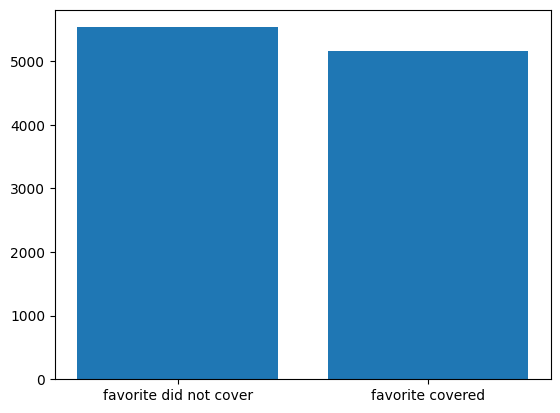

In [111]:
games['spread_favorite']
games.dropna(subset = ['spread_favorite','team_favorite_id'],inplace=True)
def covered(row):
    if row['team_favorite_id'] == row['home_abrev']:
        point_diff = row['score_home']-row['score_away']
    else:
        point_diff = row['score_away'] - row['score_home']
    if point_diff > np.abs(row['spread_favorite']):
        return True
    elif point_diff < np.abs(row['spread_favorite']):
        return False
    else:
        return np.nan
games['favorite_covered'] = games.apply(covered,axis=1)
plt.bar(x=["favorite did not cover", "favorite covered"] ,height = games['favorite_covered'].value_counts())

It looks like the spread favorite only covers the spread about 5195 / (5195 + 5570) * 100 = 48.25824431% of the time! which means the books are approximately 1.75% off when calculating their spread probabilities. 
While this may look like a small percentage, it's enough to work with and give me hope that we can in fact beat the books.


Let's look at the relationship between the predicted ELO probabilities and the actual win rates of games

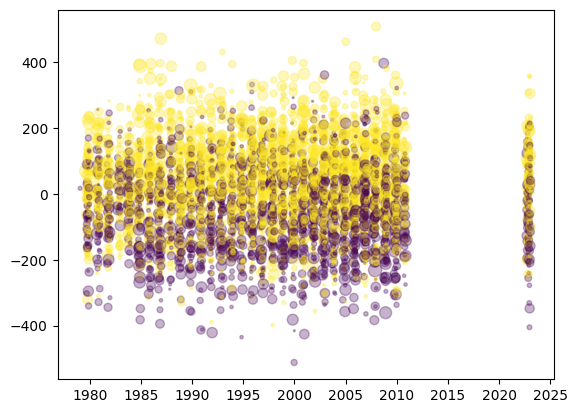

In [110]:
master_df['elo_diff'] = master_df['elo_home_pre'] - master_df['elo_away_pre']

plt.scatter(x=master_df['date'],y=master_df['elo_diff'],c=master_df['home_winner'],s= np.abs(master_df['point_diff'])*2, alpha = .3)

In [67]:
games['total'] = games['score_away'] + games['score_home']
highest_scoring = games.nlargest(n=250,columns='total')
highest_scoring.describe()

,schedule_date,schedule_season,score_home,score_away,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,weather_humidity,point_diff,point_total,total
count,250,250.000000,250.000000,250.000000,250.000000,250.000000,231.000000,230.000000,132.000000,250.000000,250.0000,250.0000
mean,2004-06-22 20:26:52.800000,2003.628000,41.720000,38.440000,-4.824000,45.224000,61.870130,5.460870,68.053030,4.728000,80.1600,80.1600
min,1979-09-02 00:00:00,1979.000000,21.000000,16.000000,-18.500000,32.000000,18.000000,0.000000,30.000000,-43.000000,74.0000,74.0000
25%,1995-03-29 12:00:00,1994.250000,37.000000,34.000000,-6.500000,42.000000,53.000000,0.000000,57.000000,-5.000000,76.0000,76.0000
50%,2006-04-26 12:00:00,2005.500000,41.000000,38.500000,-3.500000,45.000000,68.000000,6.000000,70.500000,3.000000,79.0000,79.0000
75%,2015-08-11 00:00:00,2014.750000,48.000000,44.000000,-3.000000,48.500000,72.000000,9.000000,79.000000,14.000000,83.0000,83.0000
max,2022-12-18 00:00:00,2022.000000,62.000000,59.000000,0.000000,63.500000,86.000000,18.000000,100.000000,35.000000,106.0000,106.0000
std,NaN,12.845139,7.717502,7.828893,3.276885,5.564321,14.311155,4.924384,15.072504,13.891939,6.0889,6.0889


Let's examine some of the highest ELO teams in the Superbowl era. By examining these teams we can try to look at similarities between them and see if we can identify common factors that indicate a team is on the rise. 

In [68]:
# first lets find the stronger opponent heading into a given matchup
sb_era_elo.loc[:,'stronger_team'] = sb_era_elo.loc[:,['elo1_pre','elo2_pre']].max(axis=1).copy()
#Now lets find the 250 strongest rated teams of the superbowl era and look at some summary statistics
strongest_250 = sb_era_elo.nlargest(250, columns='stronger_team')
strongest_250

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,qbelo1_pre,qbelo2_pre,qb1,qb2,qb1_value_pre,qb2_value_pre,qb1_adj,qb2_adj,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,quality,importance,total_rating,gameID,stronger_team
13336,2008-02-03,2007.0,True,s,NYG,NE,1601.818,1849.484,0.193773,0.806227,1627.007,1824.295,1605.048576,1814.366226,Eli Manning,Tom Brady,85.366753,246.566647,4.103396,22.026223,0.208674,0.791326,106.062956,94.006355,87.436373,231.310618,1631.332537,1788.082265,17.0,14.0,100.0,NaN,NaN,2008-02-03 NE vs NYG,1849.484
13335,2008-01-20,2007.0,False,c,NE,LAC,1839.663,1697.971,0.766708,0.233292,1849.484,1688.150,1806.390160,1687.110809,Tom Brady,Philip Rivers,267.613347,124.423291,34.283629,12.383898,0.786154,0.213846,57.146347,-15.761606,246.566647,110.404801,1814.366226,1679.134742,21.0,12.0,100.0,NaN,NaN,2008-01-20 LAC vs NE,1839.663
13330,2008-01-12,2007.0,False,d,NE,JAX,1831.462,1638.157,0.815616,0.184384,1839.663,1629.956,1800.256592,1643.128926,Tom Brady,David Garrard,255.689563,139.684420,29.835599,10.187894,0.829191,0.170809,374.927404,239.542769,267.613347,149.670255,1806.390160,1636.995358,31.0,20.0,100.0,NaN,NaN,2008-01-12 JAX vs NE,1831.462
13310,2007-12-29,2007.0,False,NaN,NYG,NE,1539.477,1825.961,0.218409,0.781591,1533.975,1831.462,1538.022654,1795.514049,Eli Manning,Tom Brady,34.896891,243.371393,-22.655591,24.948474,0.497834,0.502166,313.334298,366.553093,62.740632,255.689563,1533.280110,1800.256592,35.0,38.0,98.0,NaN,NaN,2007-12-29 NE vs NYG,1825.961
13298,2007-12-23,2007.0,False,NaN,NE,MIA,1824.224,1315.198,0.964578,0.035422,1825.961,1313.461,1793.913721,1305.889743,Tom Brady,Cleo Lemon,262.983762,51.295357,36.612548,-5.419163,0.967212,0.032788,66.860072,-94.395115,243.371393,36.726309,1795.514049,1304.289415,28.0,7.0,60.0,NaN,NaN,2007-12-23 MIA vs NE,1824.224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9204,1991-12-08,1991.0,False,NaN,ARI,WSH,1352.260,1721.546,0.147844,0.852156,1347.205,1726.601,1349.409281,1707.093469,Stan Gelbaugh,Mark Rypien,17.423866,168.183721,1.958113,27.709383,0.152955,0.847045,-44.630073,237.640652,11.218472,175.129414,1344.161444,1712.341307,14.0,20.0,58.0,NaN,NaN,1991-12-08 ARI vs WSH,1721.546
13361,2008-09-14,2008.0,False,NaN,NYJ,NE,1460.740,1721.511,0.244725,0.755275,1450.391,1731.860,1481.474022,1675.232667,Brett Favre,Matt Cassel,160.449467,9.068400,24.564878,-197.293232,0.622823,0.377177,101.086051,54.605788,154.513126,13.622139,1451.874090,1704.832598,10.0,19.0,45.0,NaN,NaN,2008-09-14 NE vs NYJ,1721.511
7576,1984-11-26,1984.0,False,NaN,MIA,NYJ,1721.472,1448.509,0.874952,0.125048,1726.859,1443.122,1707.638352,1459.501403,Dan Marino,Ken O'Brien,193.985754,33.391755,31.773094,21.713513,0.861228,0.138772,218.871953,51.878873,196.474374,35.240467,1713.620218,1453.519538,28.0,17.0,90.0,NaN,NaN,1984-11-26 MIA vs NYJ,1721.472
5681,1976-01-04,1975.0,False,c,LAR,DAL,1721.455,1652.334,0.683967,0.316033,1671.430,1702.358,1727.907949,1656.209864,James Harris,Roger Staubach,78.122048,160.454669,-10.379217,24.164597,0.659770,0.340230,-48.331875,355.879381,65.476656,179.997140,1680.558686,1703.559126,7.0,37.0,100.0,NaN,NaN,1976-01-04 DAL vs LAR,1721.455


In [69]:
def find_stronger_qb(row):
    if row['stronger_team'] == row['elo1_pre']:
        return row['qbelo1_pre']
    else:
        return row['qbelo2_pre']
strongest_250['stronger_team_qb_elo'] = strongest_250.apply(find_stronger_qb,axis=1)

Index(['date', 'season', 'neutral', 'playoff', 'team1', 'team2', 'elo1_pre',
       'elo2_pre', 'elo_prob1', 'elo_prob2', 'elo1_post', 'elo2_post',
       'qbelo1_pre', 'qbelo2_pre', 'qb1', 'qb2', 'qb1_value_pre',
       'qb2_value_pre', 'qb1_adj', 'qb2_adj', 'qbelo_prob1', 'qbelo_prob2',
       'qb1_game_value', 'qb2_game_value', 'qb1_value_post', 'qb2_value_post',
       'qbelo1_post', 'qbelo2_post', 'score1', 'score2', 'quality',
       'importance', 'total_rating', 'gameID', 'stronger_team'],
      dtype='object')

13336    1814.366226
13335    1806.390160
13330    1800.256592
13310    1795.514049
13298    1793.913721
            ...     
9204     1707.093469
13361    1675.232667
7576     1707.638352
5681     1727.907949
10199    1771.556278
Name: stronger_team_qb_elo, Length: 250, dtype: float64

<BarContainer object of 2 artists>

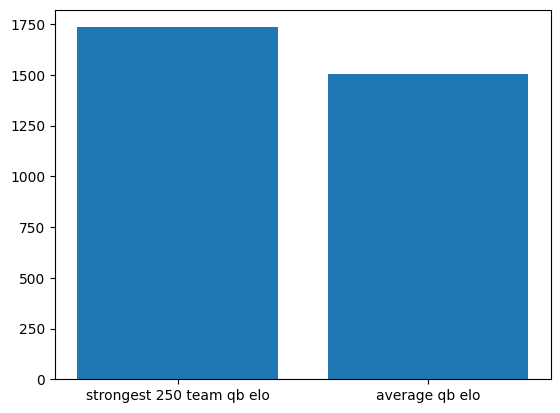

In [70]:
plt.bar(x=["strongest 250 team qb elo", "average qb elo"],height = [strongest_250['stronger_team_qb_elo'].mean(),(sb_era_elo['qbelo1_pre'].mean() + sb_era_elo['qbelo2_pre'].mean())/2])

These stats can give us a good idea of what an elite NFL team looks like. 

We can check out the correlation matrix for the superbowl era to give us a good idea of which variables are strongly related to each other

In [ ]:
sb_era_elo.corr(numeric_only=True)

#### Hypothesis
Games played in colder weather will tend to be lower scoring and therefore will not hit the over

<BarContainer object of 4 artists>

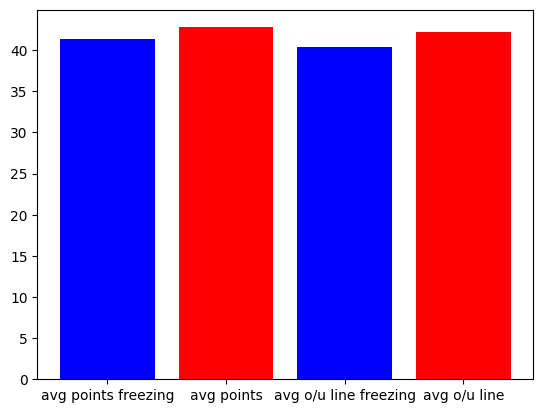

In [112]:
#Let's test out our theory
freezing = master_df[master_df['weather_temperature'] <= 32]
color = ['blue', 'red', 'blue', 'red']
plt.bar(x=['avg points freezing', 'avg points','avg o/u line freezing', 'avg o/u line'],height=[freezing['point_total'].mean(),master_df['point_total'].mean(),freezing
['over_under_line'].mean(),master_df['over_under_line'].mean()],color=color)

It doesn't look like it makes a difference, however there might be another explanation...

<Axes: >

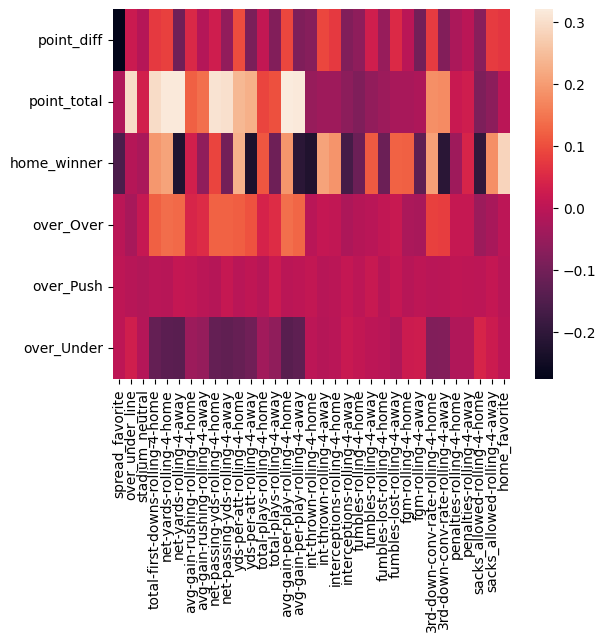

In [93]:
sns.heatmap(pd.get_dummies(master_df[features_rolling_4_game + y_regression_features + y_classification_features]).corr().filter(features_rolling_4_game).drop(features_rolling_4_game),xticklabels=True)

It looks like bookmakers are already adjusting for the weather. We need to start thinking outside the box and look for factors they haven't though about yet if we want to get an edge. 

Lets look at games that hit the over vs games that did not hit the over

In [ ]:

games['over'] = games['over'].map({0:'Red', 1:'Green', 2:'Blue'})
games.plot.scatter(x='over_under_line',y='total',c='over', alpha = .3)

This scatter plot shows us games that hit the over in green, games that hit the under in red, and games that pushed in blue, with total points on the y-axis, and the over under line on the x. This is a good way to visualize the data as we can clearly see where the over-under line is on the plot. 

# Building a Model

Onto the good stuff:
My approach for my model is will be:
- Build a Machine Learning model using the master dataframe that predicts the probability of a team winning a given game (classification)
- Build a second model that predicts point totals of a game (regression)
- potential independent variables for the models will be, Team ELOs, QB Elos, sportsbook odds, season record, momentum score (fraction of x previous games won), weather, injuries, and any other useful statitistics I can find
- Dependent variables for the model will be the winner/win probability for the first model, and the predicted score for each team in the second model
- Test the model using cross validation
- Use the predictions and probabilities from the model, along with the new odds from the Odds API to identify potential positive EV bets
- Test to see if our identified "positive EV" bets are actually profitable. 
- Repeat until we make a model that is profitable

We are going to have to build and test a lot of different models to find one that works. Let's start by building a pipeline to streamline the process. 

In [3]:
master_df.dropna(axis=1)

,gameID,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,home_abrev,away_abrev,point_diff,point_total,winner,over,total-first-downs-home,total-first-downs-away,rushing-first-downs-home,rushing-first-downs-away,passing-first-downs-home,passing-first-downs-away,penalty-first-downs-home,penalty-first-downs-away,net-yards-home,net-yards-away,net-rushing-yds-home,net-rushing-yds-away,rushing-plays-home,rushing-plays-away,avg-gain-rushing-home,avg-gain-rushing-away,net-passing-yds-home,net-passing-yds-away,gross-passing-yds-home,gross-passing-yds-away,yds-per-att-home,yds-per-att-away,total-plays-home,total-plays-away,avg-gain-per-play-home,avg-gain-per-play-away,date-home,date-away,matchup-home,matchup-away,passing-attempts-home,passing-attempts-away,completions-home,completions-away,int-thrown-home,int-thrown-away,fumbles-home,fumbles-away,fumbles-lost-home,fumbles-lost-away,3rd-down-convs-home,3rd-down-convs-away,3rd-downs-home,3rd-downs-away,3rd-down-conv-rate-home,3rd-down-conv-rate-away,penalties-home,penalties-away,penalty-yards-home,penalty-yards-away,sacks_allowed-home,sacks_allowed-away,sack-yds-lost-home,sack-yds-lost-away,punts-returned-home,punts-returned-away,punt-return-yds-home,punt-return-yds-away,kicks-returned-home,kicks-returned-away,kick-return-yds-home,kick-return-yds-away,team-abrev-home,team-abrev-away,Unnamed: 0-rolling-4-home,Unnamed: 0-rolling-4-away,total-first-downs-rolling-4-home,total-first-downs-rolling-4-away,rushing-first-downs-rolling-4-home,rushing-first-downs-rolling-4-away,passing-first-downs-rolling-4-home,passing-first-downs-rolling-4-away,penalty-first-downs-rolling-4-home,penalty-first-downs-rolling-4-away,net-yards-rolling-4-home,net-yards-rolling-4-away,net-rushing-yds-rolling-4-home,net-rushing-yds-rolling-4-away,rushing-plays-rolling-4-home,rushing-plays-rolling-4-away,avg-gain-rushing-rolling-4-home,avg-gain-rushing-rolling-4-away,net-passing-yds-rolling-4-home,net-passing-yds-rolling-4-away,gross-passing-yds-rolling-4-home,gross-passing-yds-rolling-4-away,yds-per-att-rolling-4-home,yds-per-att-rolling-4-away,blocked-kicks-allowed-rolling-4-home,blocked-kicks-allowed-rolling-4-away,total-plays-rolling-4-home,total-plays-rolling-4-away,avg-gain-per-play-rolling-4-home,avg-gain-per-play-rolling-4-away,passing-attempts-rolling-4-home,passing-attempts-rolling-4-away,completions-rolling-4-home,completions-rolling-4-away,int-thrown-rolling-4-home,int-thrown-rolling-4-away,fumbles-rolling-4-home,fumbles-rolling-4-away,fumbles-lost-rolling-4-home,fumbles-lost-rolling-4-away,fga-rolling-4-home,fga-rolling-4-away,fgm-rolling-4-home,fgm-rolling-4-away,3rd-down-convs-rolling-4-home,3rd-down-convs-rolling-4-away,3rd-downs-rolling-4-home,3rd-downs-rolling-4-away,3rd-down-conv-rate-rolling-4-home,3rd-down-conv-rate-rolling-4-away,punts-rolling-4-home,punts-rolling-4-away,yards-per-punt-rolling-4-home,yards-per-punt-rolling-4-away,penalties-rolling-4-home,penalties-rolling-4-away,penalty-yards-rolling-4-home,penalty-yards-rolling-4-away,sacks_allowed-rolling-4-home,sacks_allowed-rolling-4-away,sack-yds-lost-rolling-4-home,sack-yds-lost-rolling-4-away,punts-returned-rolling-4-home,punts-returned-rolling-4-away,punt-return-yds-rolling-4-home,punt-return-yds-rolling-4-away,kicks-returned-rolling-4-home,kicks-returned-rolling-4-away,kick-return-yds-rolling-4-home,kick-return-yds-rolling-4-away,Unnamed: 0-rolling-8-home,Unnamed: 0-rolling-8-away,total-first-downs-rolling-8-home,total-first-downs-rolling-8-away,rushing-first-downs-rolling-8-home,rushing-first-downs-rolling-8-away,passing-first-downs-rolling-8-home,passing-first-downs-rolling-8-away,penalty-first-downs-rolling-8-home,penalty-first-downs-rolling-8-away,net-yards-rolling-8-home,net-yards-rolling-8-away,net-rushing-yds-rolling-8-home,net-rushing-yds-rolling-8-away,rushing-plays-rolling-8-home,rushing-plays-rolling-8-away

In [15]:
def check_covered(df):
    if np.abs(df['spread_favorite']) > df['point_diff']:
        return "Home"
    elif np.abs(df['spread_favorite']) < df['point_diff']:
        return "Away"
    else:
        return "push"

master_df['covered'] = master_df.apply(check_covered,axis=1)

In [145]:
from sklearn.linear_model import LogisticRegression, SGDRegressor, BayesianRidge
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from multiprocessing import Pool
from sklearn.feature_selection import SequentialFeatureSelector
# vec = DictVectorizer(sparse = False)
# vec.fit(x_dict)
# x_train = vec.transform(x_dict)
classifiers = [LogisticRegression,GradientBoostingClassifier,KNeighborsClassifier,RandomForestClassifier]
knn_params = {
    'scaler':[StandardScaler()],
    'selector__threshold':[.001,.01,],
    'vec__sparse':[False],
    'clf__n_neighbors':[10,25,50,100],
    'clf__weights':['distance','uniform'],
}
gradient_boosting_random_forest_params = {
    'scaler':[MaxAbsScaler()],
    'selector__threshold':[.01],
    'vec__sparse':[False],
    'clf__n_estimators':[1000],
    'clf__min_samples_split':[2],
    'clf__min_samples_leaf':[1]
}
model_to_params = {
    LogisticRegression:logistic_regression_params,
    GradientBoostingClassifier:gradient_boosting_random_forest_params,
    RandomForestClassifier:gradient_boosting_random_forest_params,
    KNeighborsClassifier:knn_params
}
logistic_regression_params = {
    'scaler':[MaxAbsScaler()],
    'selector__threshold':[.001,.01,.002],
    'vec__sparse':[False],
    "clf__max_iter":[3000,5000],
    "clf__multi_class":['multinomial'],
    "clf__class_weight":[None]
}

scores = []
x_features = [
 'spread_favorite',
 'over_under_line',
 'total-first-downs-rolling-4-home',
 'total-first-downs-rolling-4-away',
 'rushing-first-downs-rolling-4-home',
 'rushing-first-downs-rolling-4-away',
 'passing-first-downs-rolling-4-home',
 'passing-first-downs-rolling-4-away',
 'penalty-first-downs-rolling-4-home',
 'penalty-first-downs-rolling-4-away',
 'net-yards-rolling-4-home',
 'net-yards-rolling-4-away',
 'net-rushing-yds-rolling-4-home',
 'net-rushing-yds-rolling-4-away',
 'rushing-plays-rolling-4-home',
 'rushing-plays-rolling-4-away',
 'avg-gain-rushing-rolling-4-home',
 'avg-gain-rushing-rolling-4-away',
 'net-passing-yds-rolling-4-home',
 'net-passing-yds-rolling-4-away',
 'gross-passing-yds-rolling-4-home',
 'gross-passing-yds-rolling-4-away',
 'yds-per-att-rolling-4-home',
 'yds-per-att-rolling-4-away',
 'blocked-kicks-allowed-rolling-4-home',
 'blocked-kicks-allowed-rolling-4-away',
 'total-plays-rolling-4-home',
 'total-plays-rolling-4-away',
 'avg-gain-per-play-rolling-4-home',
 'avg-gain-per-play-rolling-4-away',
 'passing-attempts-rolling-4-home',
 'passing-attempts-rolling-4-away',
 'completions-rolling-4-home',
 'completions-rolling-4-away',
 'int-thrown-rolling-4-home',
 'int-thrown-rolling-4-away',
 'fumbles-rolling-4-home',
 'fumbles-rolling-4-away',
 'fumbles-lost-rolling-4-home',
 'fumbles-lost-rolling-4-away',
 'fga-rolling-4-home',
 'fga-rolling-4-away',
 'fgm-rolling-4-home',
 'fgm-rolling-4-away',
 '3rd-down-convs-rolling-4-home',
 '3rd-down-convs-rolling-4-away',
 '3rd-downs-rolling-4-home',
 '3rd-downs-rolling-4-away',
 '3rd-down-conv-rate-rolling-4-home',
 '3rd-down-conv-rate-rolling-4-away',
 'punts-rolling-4-home',
 'punts-rolling-4-away',
 'yards-per-punt-rolling-4-home',
 'yards-per-punt-rolling-4-away',
 'penalties-rolling-4-home',
 'penalties-rolling-4-away',
 'penalty-yards-rolling-4-home',
 'penalty-yards-rolling-4-away',
 'sacks_allowed-rolling-4-home',
 'sacks_allowed-rolling-4-away',
 'sack-yds-lost-rolling-4-home',
 'sack-yds-lost-rolling-4-away',
 'punts-returned-rolling-4-home',
 'punts-returned-rolling-4-away',
 'punt-return-yds-rolling-4-home',
 'punt-return-yds-rolling-4-away',
 'kicks-returned-rolling-4-home',
 'kicks-returned-rolling-4-away',
 'kick-return-yds-rolling-4-home',
 'kick-return-yds-rolling-4-away',
 'total-first-downs-rolling-8-home',
 'total-first-downs-rolling-8-away',
 'rushing-first-downs-rolling-8-home',
 'rushing-first-downs-rolling-8-away',
 'passing-first-downs-rolling-8-home',
 'passing-first-downs-rolling-8-away',
 'penalty-first-downs-rolling-8-home',
 'penalty-first-downs-rolling-8-away',
 'net-yards-rolling-8-home',
 'net-yards-rolling-8-away',
 'net-rushing-yds-rolling-8-home',
 'net-rushing-yds-rolling-8-away',
 'rushing-plays-rolling-8-home',
 'rushing-plays-rolling-8-away',
 'avg-gain-rushing-rolling-8-home',
 'avg-gain-rushing-rolling-8-away',
 'net-passing-yds-rolling-8-home',
 'net-passing-yds-rolling-8-away',
 'gross-passing-yds-rolling-8-home',
 'gross-passing-yds-rolling-8-away',
 'yds-per-att-rolling-8-home',
 'yds-per-att-rolling-8-away',
 'blocked-kicks-allowed-rolling-8-home',
 'blocked-kicks-allowed-rolling-8-away',
 'total-plays-rolling-8-home',
 'total-plays-rolling-8-away',
 'avg-gain-per-play-rolling-8-home',
 'avg-gain-per-play-rolling-8-away',
 'passing-attempts-rolling-8-home',
 'passing-attempts-rolling-8-away',
 'completions-rolling-8-home',
 'completions-rolling-8-away',
 'int-thrown-rolling-8-home',
 'int-thrown-rolling-8-away',
 'interceptions-rolling-8-home',
 'interceptions-rolling-8-away',
 'int-return-yards-rolling-8-home',
 'int-return-yards-rolling-8-away',
 'fumbles-rolling-8-home',
 'fumbles-rolling-8-away',
 'fumbles-lost-rolling-8-home',
 'fumbles-lost-rolling-8-away',
 'fga-rolling-8-home',
 'fga-rolling-8-away',
 'fgm-rolling-8-home',
 'fgm-rolling-8-away',
 '3rd-down-convs-rolling-8-home',
 '3rd-down-convs-rolling-8-away',
 '3rd-downs-rolling-8-home',
 '3rd-downs-rolling-8-away',
 '3rd-down-conv-rate-rolling-8-home',
 '3rd-down-conv-rate-rolling-8-away',
 'punts-rolling-8-home',
 'punts-rolling-8-away',
 'yards-per-punt-rolling-8-home',
 'yards-per-punt-rolling-8-away',
 'penalties-rolling-8-home',
 'penalties-rolling-8-away',
 'penalty-yards-rolling-8-home',
 'penalty-yards-rolling-8-away',
 'sacks_allowed-rolling-8-home',
 'sacks_allowed-rolling-8-away',
 'sack-yds-lost-rolling-8-home',
 'sack-yds-lost-rolling-8-away',
 'punts-returned-rolling-8-home',
 'punts-returned-rolling-8-away',
 'punt-return-yds-rolling-8-home',
 'punt-return-yds-rolling-8-away',
 'kicks-returned-rolling-8-home',
 'kicks-returned-rolling-8-away',
 'kick-return-yds-rolling-8-home',
 'kick-return-yds-rolling-8-away',
 'total-first-downs-rolling-16-home',
 'total-first-downs-rolling-16-away',
 'rushing-first-downs-rolling-16-home',
 'rushing-first-downs-rolling-16-away',
 'passing-first-downs-rolling-16-home',
 'passing-first-downs-rolling-16-away',
 'penalty-first-downs-rolling-16-home',
 'penalty-first-downs-rolling-16-away',
 'net-yards-rolling-16-home',
 'net-yards-rolling-16-away',
 'net-rushing-yds-rolling-16-home',
 'net-rushing-yds-rolling-16-away',
 'rushing-plays-rolling-16-home',
 'rushing-plays-rolling-16-away',
 'avg-gain-rushing-rolling-16-home',
 'avg-gain-rushing-rolling-16-away',
 'net-passing-yds-rolling-16-home',
 'net-passing-yds-rolling-16-away',
 'gross-passing-yds-rolling-16-home',
 'gross-passing-yds-rolling-16-away',
 'yds-per-att-rolling-16-home',
 'yds-per-att-rolling-16-away',
 'blocked-kicks-allowed-rolling-16-home',
 'blocked-kicks-allowed-rolling-16-away',
 'total-plays-rolling-16-home',
 'total-plays-rolling-16-away',
 'avg-gain-per-play-rolling-16-home',
 'avg-gain-per-play-rolling-16-away',
 'passing-attempts-rolling-16-home',
 'passing-attempts-rolling-16-away',
 'completions-rolling-16-home',
 'completions-rolling-16-away',
 'int-thrown-rolling-16-home',
 'int-thrown-rolling-16-away',
 'interceptions-rolling-16-home',
 'interceptions-rolling-16-away',
 'int-return-yards-rolling-16-home',
 'int-return-yards-rolling-16-away',
 'fumbles-rolling-16-home',
 'fumbles-rolling-16-away',
 'fumbles-lost-rolling-16-home',
 'fumbles-lost-rolling-16-away',
 'fga-rolling-16-home',
 'fga-rolling-16-away',
 'fgm-rolling-16-home',
 'fgm-rolling-16-away',
 '3rd-down-convs-rolling-16-home',
 '3rd-down-convs-rolling-16-away',
 '3rd-downs-rolling-16-home',
 '3rd-downs-rolling-16-away',
 '3rd-down-conv-rate-rolling-16-home',
 '3rd-down-conv-rate-rolling-16-away',
 'punts-rolling-16-home',
 'punts-rolling-16-away',
 'yards-per-punt-rolling-16-home',
 'yards-per-punt-rolling-16-away',
 'penalties-rolling-16-home',
 'penalties-rolling-16-away',
 'penalty-yards-rolling-16-home',
 'penalty-yards-rolling-16-away',
 'sacks_allowed-rolling-16-home',
 'sacks_allowed-rolling-16-away',
 'sack-yds-lost-rolling-16-home',
 'sack-yds-lost-rolling-16-away',
 'punts-returned-rolling-16-home',
 'punts-returned-rolling-16-away',
 'punt-return-yds-rolling-16-home',
 'punt-return-yds-rolling-16-away',
 'kicks-returned-rolling-16-home',
 'kicks-returned-rolling-16-away',
 'kick-return-yds-rolling-16-home',
 'kick-return-yds-rolling-16-away',
 'home_favorite',]


features = x_features + [y_feat]
training_data = master_df[features].dropna(axis=1)
x_dict = training_data[x_features].to_dict(orient="records")
y_train = training_data[y_feat]
pipe = Pipeline([("vec",DictVectorizer()),("scaler",StandardScaler()),("selector",VarianceThreshold()),("clf",model())])
if y_feat == "home_winner":
    scoring = {"accuracy":"balanced_accuracy","brier score":"neg_brier_score","precision":"precision_micro","recall":"recall_micro","f1":"f1_micro"}
    metric = "brier score"
else:
    scoring = {"accuracy":"balanced_accuracy"}
    metric = "accuracy"
grid = GridSearchCV(estimator=pipe,param_grid=params,cv=10,scoring=scoring,refit=metric,n_jobs=3)
grid.fit(x_dict,y_train)
score = grid.score(x_dict)
best_params = grid.best_params_
best_score = grid.best_score_
scores.append(f"feature: {y_feat} | model: {model} | best parameters: {best_params} | best score: {best_score}, all scores: {score}")

NameError: name 'scores' is not defined

In [146]:
param_search('over',gradient_boosting_random_forest_params,GradientBoostingClassifier)

InvalidParameterError: The 'y_true' parameter of balanced_accuracy_score must be an array-like. Got None instead.

In [141]:
def get_cv_error(model,y_feat):
    x_features = [
 'spread_favorite',
 'over_under_line',
 'total-first-downs-rolling-4-home',
 'total-first-downs-rolling-4-away',
 'rushing-first-downs-rolling-4-home',
 'rushing-first-downs-rolling-4-away',
 'passing-first-downs-rolling-4-home',
 'passing-first-downs-rolling-4-away',
 'penalty-first-downs-rolling-4-home',
 'penalty-first-downs-rolling-4-away',
 'net-yards-rolling-4-home',
 'net-yards-rolling-4-away',
 'net-rushing-yds-rolling-4-home',
 'net-rushing-yds-rolling-4-away',
 'rushing-plays-rolling-4-home',
 'rushing-plays-rolling-4-away',
 'avg-gain-rushing-rolling-4-home',
 'avg-gain-rushing-rolling-4-away',
 'net-passing-yds-rolling-4-home',
 'net-passing-yds-rolling-4-away',
 'gross-passing-yds-rolling-4-home',
 'gross-passing-yds-rolling-4-away',
 'yds-per-att-rolling-4-home',
 'yds-per-att-rolling-4-away',
 'blocked-kicks-allowed-rolling-4-home',
 'blocked-kicks-allowed-rolling-4-away',
 'total-plays-rolling-4-home',
 'total-plays-rolling-4-away',
 'avg-gain-per-play-rolling-4-home',
 'avg-gain-per-play-rolling-4-away',
 'passing-attempts-rolling-4-home',
 'passing-attempts-rolling-4-away',
 'completions-rolling-4-home',
 'completions-rolling-4-away',
 'int-thrown-rolling-4-home',
 'int-thrown-rolling-4-away',
 'fumbles-rolling-4-home',
 'fumbles-rolling-4-away',
 'fumbles-lost-rolling-4-home',
 'fumbles-lost-rolling-4-away',
 'fga-rolling-4-home',
 'fga-rolling-4-away',
 'fgm-rolling-4-home',
 'fgm-rolling-4-away',
 '3rd-down-convs-rolling-4-home',
 '3rd-down-convs-rolling-4-away',
 '3rd-downs-rolling-4-home',
 '3rd-downs-rolling-4-away',
 '3rd-down-conv-rate-rolling-4-home',
 '3rd-down-conv-rate-rolling-4-away',
 'punts-rolling-4-home',
 'punts-rolling-4-away',
 'yards-per-punt-rolling-4-home',
 'yards-per-punt-rolling-4-away',
 'penalties-rolling-4-home',
 'penalties-rolling-4-away',
 'penalty-yards-rolling-4-home',
 'penalty-yards-rolling-4-away',
 'sacks_allowed-rolling-4-home',
 'sacks_allowed-rolling-4-away',
 'sack-yds-lost-rolling-4-home',
 'sack-yds-lost-rolling-4-away',
 'punts-returned-rolling-4-home',
 'punts-returned-rolling-4-away',
 'punt-return-yds-rolling-4-home',
 'punt-return-yds-rolling-4-away',
 'kicks-returned-rolling-4-home',
 'kicks-returned-rolling-4-away',
 'kick-return-yds-rolling-4-home',
 'kick-return-yds-rolling-4-away',
 'total-first-downs-rolling-8-home',
 'total-first-downs-rolling-8-away',
 'rushing-first-downs-rolling-8-home',
 'rushing-first-downs-rolling-8-away',
 'passing-first-downs-rolling-8-home',
 'passing-first-downs-rolling-8-away',
 'penalty-first-downs-rolling-8-home',
 'penalty-first-downs-rolling-8-away',
 'net-yards-rolling-8-home',
 'net-yards-rolling-8-away',
 'net-rushing-yds-rolling-8-home',
 'net-rushing-yds-rolling-8-away',
 'rushing-plays-rolling-8-home',
 'rushing-plays-rolling-8-away',
 'avg-gain-rushing-rolling-8-home',
 'avg-gain-rushing-rolling-8-away',
 'net-passing-yds-rolling-8-home',
 'net-passing-yds-rolling-8-away',
 'gross-passing-yds-rolling-8-home',
 'gross-passing-yds-rolling-8-away',
 'yds-per-att-rolling-8-home',
 'yds-per-att-rolling-8-away',
 'blocked-kicks-allowed-rolling-8-home',
 'blocked-kicks-allowed-rolling-8-away',
 'total-plays-rolling-8-home',
 'total-plays-rolling-8-away',
 'avg-gain-per-play-rolling-8-home',
 'avg-gain-per-play-rolling-8-away',
 'passing-attempts-rolling-8-home',
 'passing-attempts-rolling-8-away',
 'completions-rolling-8-home',
 'completions-rolling-8-away',
 'int-thrown-rolling-8-home',
 'int-thrown-rolling-8-away',
 'interceptions-rolling-8-home',
 'interceptions-rolling-8-away',
 'int-return-yards-rolling-8-home',
 'int-return-yards-rolling-8-away',
 'fumbles-rolling-8-home',
 'fumbles-rolling-8-away',
 'fumbles-lost-rolling-8-home',
 'fumbles-lost-rolling-8-away',
 'fga-rolling-8-home',
 'fga-rolling-8-away',
 'fgm-rolling-8-home',
 'fgm-rolling-8-away',
 '3rd-down-convs-rolling-8-home',
 '3rd-down-convs-rolling-8-away',
 '3rd-downs-rolling-8-home',
 '3rd-downs-rolling-8-away',
 '3rd-down-conv-rate-rolling-8-home',
 '3rd-down-conv-rate-rolling-8-away',
 'punts-rolling-8-home',
 'punts-rolling-8-away',
 'yards-per-punt-rolling-8-home',
 'yards-per-punt-rolling-8-away',
 'penalties-rolling-8-home',
 'penalties-rolling-8-away',
 'penalty-yards-rolling-8-home',
 'penalty-yards-rolling-8-away',
 'sacks_allowed-rolling-8-home',
 'sacks_allowed-rolling-8-away',
 'sack-yds-lost-rolling-8-home',
 'sack-yds-lost-rolling-8-away',
 'punts-returned-rolling-8-home',
 'punts-returned-rolling-8-away',
 'punt-return-yds-rolling-8-home',
 'punt-return-yds-rolling-8-away',
 'kicks-returned-rolling-8-home',
 'kicks-returned-rolling-8-away',
 'kick-return-yds-rolling-8-home',
 'kick-return-yds-rolling-8-away',
 'total-first-downs-rolling-16-home',
 'total-first-downs-rolling-16-away',
 'rushing-first-downs-rolling-16-home',
 'rushing-first-downs-rolling-16-away',
 'passing-first-downs-rolling-16-home',
 'passing-first-downs-rolling-16-away',
 'penalty-first-downs-rolling-16-home',
 'penalty-first-downs-rolling-16-away',
 'net-yards-rolling-16-home',
 'net-yards-rolling-16-away',
 'net-rushing-yds-rolling-16-home',
 'net-rushing-yds-rolling-16-away',
 'rushing-plays-rolling-16-home',
 'rushing-plays-rolling-16-away',
 'avg-gain-rushing-rolling-16-home',
 'avg-gain-rushing-rolling-16-away',
 'net-passing-yds-rolling-16-home',
 'net-passing-yds-rolling-16-away',
 'gross-passing-yds-rolling-16-home',
 'gross-passing-yds-rolling-16-away',
 'yds-per-att-rolling-16-home',
 'yds-per-att-rolling-16-away',
 'blocked-kicks-allowed-rolling-16-home',
 'blocked-kicks-allowed-rolling-16-away',
 'total-plays-rolling-16-home',
 'total-plays-rolling-16-away',
 'avg-gain-per-play-rolling-16-home',
 'avg-gain-per-play-rolling-16-away',
 'passing-attempts-rolling-16-home',
 'passing-attempts-rolling-16-away',
 'completions-rolling-16-home',
 'completions-rolling-16-away',
 'int-thrown-rolling-16-home',
 'int-thrown-rolling-16-away',
 'interceptions-rolling-16-home',
 'interceptions-rolling-16-away',
 'int-return-yards-rolling-16-home',
 'int-return-yards-rolling-16-away',
 'fumbles-rolling-16-home',
 'fumbles-rolling-16-away',
 'fumbles-lost-rolling-16-home',
 'fumbles-lost-rolling-16-away',
 'fga-rolling-16-home',
 'fga-rolling-16-away',
 'fgm-rolling-16-home',
 'fgm-rolling-16-away',
 '3rd-down-convs-rolling-16-home',
 '3rd-down-convs-rolling-16-away',
 '3rd-downs-rolling-16-home',
 '3rd-downs-rolling-16-away',
 '3rd-down-conv-rate-rolling-16-home',
 '3rd-down-conv-rate-rolling-16-away',
 'punts-rolling-16-home',
 'punts-rolling-16-away',
 'yards-per-punt-rolling-16-home',
 'yards-per-punt-rolling-16-away',
 'penalties-rolling-16-home',
 'penalties-rolling-16-away',
 'penalty-yards-rolling-16-home',
 'penalty-yards-rolling-16-away',
 'sacks_allowed-rolling-16-home',
 'sacks_allowed-rolling-16-away',
 'sack-yds-lost-rolling-16-home',
 'sack-yds-lost-rolling-16-away',
 'punts-returned-rolling-16-home',
 'punts-returned-rolling-16-away',
 'punt-return-yds-rolling-16-home',
 'punt-return-yds-rolling-16-away',
 'kicks-returned-rolling-16-home',
 'kicks-returned-rolling-16-away',
 'kick-return-yds-rolling-16-home',
 'kick-return-yds-rolling-16-away',
 'home_favorite',]
    features = x_features + [y_feat]
    training_data = master_df[features].dropna(axis=1)
    x_dict = training_data[x_features].to_dict(orient="records")
    y_train = training_data[y_feat]
    pipe = Pipeline([("vec",DictVectorizer(sparse=False)),("scaler",StandardScaler(with_mean=False)),("selector",VarianceThreshold(threshold=.001)),("clf",model)])
    if y_feat == "home_winner":
        scoring_metrics = {"accuracy":"balanced_accuracy","brier score":"neg_brier_score","f1":"f1_micro"}
    else:
        scoring_metrics = {"accuracy":"balanced_accuracy","f1":"f1_weighted"}
    score = cross_validate(pipe,x_dict,y_train,scoring=scoring_metrics,error_score='raise')
    return score

get_cv_error(RandomForestClassifier(),'over')

c:\Users\jonat\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jonat\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'fit_time': array([18.89391756, 18.92556882, 20.402426  , 18.98022985, 17.41741085]),
 'score_time': array([0.33812284, 0.52060866, 0.39195228, 0.36302853, 0.56748176]),
 'test_accuracy': array([0.41555544, 0.43587389, 0.44042639, 0.41177528, 0.39358609]),
 'test_precision': array([0.62552853, 0.62979261, 0.64110482, 0.59710715, 0.59413007]),
 'test_recall': array([0.61660079, 0.64144551, 0.64689266, 0.60564972, 0.58531073]),
 'test_f1': array([0.59487058, 0.63543992, 0.63969795, 0.60005867, 0.55429103])}

In [19]:
x_features = [
 'spread_favorite',
 'over_under_line',
 'total-first-downs-rolling-4-home',
 'total-first-downs-rolling-4-away',
 'rushing-first-downs-rolling-4-home',
 'rushing-first-downs-rolling-4-away',
 'passing-first-downs-rolling-4-home',
 'passing-first-downs-rolling-4-away',
 'penalty-first-downs-rolling-4-home',
 'penalty-first-downs-rolling-4-away',
 'net-yards-rolling-4-home',
 'net-yards-rolling-4-away',
 'net-rushing-yds-rolling-4-home',
 'net-rushing-yds-rolling-4-away',
 'rushing-plays-rolling-4-home',
 'rushing-plays-rolling-4-away',
 'avg-gain-rushing-rolling-4-home',
 'avg-gain-rushing-rolling-4-away',
 'net-passing-yds-rolling-4-home',
 'net-passing-yds-rolling-4-away',
 'gross-passing-yds-rolling-4-home',
 'gross-passing-yds-rolling-4-away',
 'yds-per-att-rolling-4-home',
 'yds-per-att-rolling-4-away',
 'blocked-kicks-allowed-rolling-4-home',
 'blocked-kicks-allowed-rolling-4-away',
 'total-plays-rolling-4-home',
 'total-plays-rolling-4-away',
 'avg-gain-per-play-rolling-4-home',
 'avg-gain-per-play-rolling-4-away',
 'passing-attempts-rolling-4-home',
 'passing-attempts-rolling-4-away',
 'completions-rolling-4-home',
 'completions-rolling-4-away',
 'int-thrown-rolling-4-home',
 'int-thrown-rolling-4-away',
 'fumbles-rolling-4-home',
 'fumbles-rolling-4-away',
 'fumbles-lost-rolling-4-home',
 'fumbles-lost-rolling-4-away',
 'fga-rolling-4-home',
 'fga-rolling-4-away',
 'fgm-rolling-4-home',
 'fgm-rolling-4-away',
 '3rd-down-convs-rolling-4-home',
 '3rd-down-convs-rolling-4-away',
 '3rd-downs-rolling-4-home',
 '3rd-downs-rolling-4-away',
 '3rd-down-conv-rate-rolling-4-home',
 '3rd-down-conv-rate-rolling-4-away',
 'punts-rolling-4-home',
 'punts-rolling-4-away',
 'yards-per-punt-rolling-4-home',
 'yards-per-punt-rolling-4-away',
 'penalties-rolling-4-home',
 'penalties-rolling-4-away',
 'penalty-yards-rolling-4-home',
 'penalty-yards-rolling-4-away',
 'sacks_allowed-rolling-4-home',
 'sacks_allowed-rolling-4-away',
 'sack-yds-lost-rolling-4-home',
 'sack-yds-lost-rolling-4-away',
 'punts-returned-rolling-4-home',
 'punts-returned-rolling-4-away',
 'punt-return-yds-rolling-4-home',
 'punt-return-yds-rolling-4-away',
 'kicks-returned-rolling-4-home',
 'kicks-returned-rolling-4-away',
 'kick-return-yds-rolling-4-home',
 'kick-return-yds-rolling-4-away',
 'total-first-downs-rolling-8-home',
 'total-first-downs-rolling-8-away',
 'rushing-first-downs-rolling-8-home',
 'rushing-first-downs-rolling-8-away',
 'passing-first-downs-rolling-8-home',
 'passing-first-downs-rolling-8-away',
 'penalty-first-downs-rolling-8-home',
 'penalty-first-downs-rolling-8-away',
 'net-yards-rolling-8-home',
 'net-yards-rolling-8-away',
 'net-rushing-yds-rolling-8-home',
 'net-rushing-yds-rolling-8-away',
 'rushing-plays-rolling-8-home',
 'rushing-plays-rolling-8-away',
 'avg-gain-rushing-rolling-8-home',
 'avg-gain-rushing-rolling-8-away',
 'net-passing-yds-rolling-8-home',
 'net-passing-yds-rolling-8-away',
 'gross-passing-yds-rolling-8-home',
 'gross-passing-yds-rolling-8-away',
 'yds-per-att-rolling-8-home',
 'yds-per-att-rolling-8-away',
 'blocked-kicks-allowed-rolling-8-home',
 'blocked-kicks-allowed-rolling-8-away',
 'total-plays-rolling-8-home',
 'total-plays-rolling-8-away',
 'avg-gain-per-play-rolling-8-home',
 'avg-gain-per-play-rolling-8-away',
 'passing-attempts-rolling-8-home',
 'passing-attempts-rolling-8-away',
 'completions-rolling-8-home',
 'completions-rolling-8-away',
 'int-thrown-rolling-8-home',
 'int-thrown-rolling-8-away',
 'interceptions-rolling-8-home',
 'interceptions-rolling-8-away',
 'int-return-yards-rolling-8-home',
 'int-return-yards-rolling-8-away',
 'fumbles-rolling-8-home',
 'fumbles-rolling-8-away',
 'fumbles-lost-rolling-8-home',
 'fumbles-lost-rolling-8-away',
 'fga-rolling-8-home',
 'fga-rolling-8-away',
 'fgm-rolling-8-home',
 'fgm-rolling-8-away',
 '3rd-down-convs-rolling-8-home',
 '3rd-down-convs-rolling-8-away',
 '3rd-downs-rolling-8-home',
 '3rd-downs-rolling-8-away',
 '3rd-down-conv-rate-rolling-8-home',
 '3rd-down-conv-rate-rolling-8-away',
 'punts-rolling-8-home',
 'punts-rolling-8-away',
 'yards-per-punt-rolling-8-home',
 'yards-per-punt-rolling-8-away',
 'penalties-rolling-8-home',
 'penalties-rolling-8-away',
 'penalty-yards-rolling-8-home',
 'penalty-yards-rolling-8-away',
 'sacks_allowed-rolling-8-home',
 'sacks_allowed-rolling-8-away',
 'sack-yds-lost-rolling-8-home',
 'sack-yds-lost-rolling-8-away',
 'punts-returned-rolling-8-home',
 'punts-returned-rolling-8-away',
 'punt-return-yds-rolling-8-home',
 'punt-return-yds-rolling-8-away',
 'kicks-returned-rolling-8-home',
 'kicks-returned-rolling-8-away',
 'kick-return-yds-rolling-8-home',
 'kick-return-yds-rolling-8-away',
 'total-first-downs-rolling-16-home',
 'total-first-downs-rolling-16-away',
 'rushing-first-downs-rolling-16-home',
 'rushing-first-downs-rolling-16-away',
 'passing-first-downs-rolling-16-home',
 'passing-first-downs-rolling-16-away',
 'penalty-first-downs-rolling-16-home',
 'penalty-first-downs-rolling-16-away',
 'net-yards-rolling-16-home',
 'net-yards-rolling-16-away',
 'net-rushing-yds-rolling-16-home',
 'net-rushing-yds-rolling-16-away',
 'rushing-plays-rolling-16-home',
 'rushing-plays-rolling-16-away',
 'avg-gain-rushing-rolling-16-home',
 'avg-gain-rushing-rolling-16-away',
 'net-passing-yds-rolling-16-home',
 'net-passing-yds-rolling-16-away',
 'gross-passing-yds-rolling-16-home',
 'gross-passing-yds-rolling-16-away',
 'yds-per-att-rolling-16-home',
 'yds-per-att-rolling-16-away',
 'blocked-kicks-allowed-rolling-16-home',
 'blocked-kicks-allowed-rolling-16-away',
 'total-plays-rolling-16-home',
 'total-plays-rolling-16-away',
 'avg-gain-per-play-rolling-16-home',
 'avg-gain-per-play-rolling-16-away',
 'passing-attempts-rolling-16-home',
 'passing-attempts-rolling-16-away',
 'completions-rolling-16-home',
 'completions-rolling-16-away',
 'int-thrown-rolling-16-home',
 'int-thrown-rolling-16-away',
 'interceptions-rolling-16-home',
 'interceptions-rolling-16-away',
 'int-return-yards-rolling-16-home',
 'int-return-yards-rolling-16-away',
 'fumbles-rolling-16-home',
 'fumbles-rolling-16-away',
 'fumbles-lost-rolling-16-home',
 'fumbles-lost-rolling-16-away',
 'fga-rolling-16-home',
 'fga-rolling-16-away',
 'fgm-rolling-16-home',
 'fgm-rolling-16-away',
 '3rd-down-convs-rolling-16-home',
 '3rd-down-convs-rolling-16-away',
 '3rd-downs-rolling-16-home',
 '3rd-downs-rolling-16-away',
 '3rd-down-conv-rate-rolling-16-home',
 '3rd-down-conv-rate-rolling-16-away',
 'punts-rolling-16-home',
 'punts-rolling-16-away',
 'yards-per-punt-rolling-16-home',
 'yards-per-punt-rolling-16-away',
 'penalties-rolling-16-home',
 'penalties-rolling-16-away',
 'penalty-yards-rolling-16-home',
 'penalty-yards-rolling-16-away',
 'sacks_allowed-rolling-16-home',
 'sacks_allowed-rolling-16-away',
 'sack-yds-lost-rolling-16-home',
 'sack-yds-lost-rolling-16-away',
 'punts-returned-rolling-16-home',
 'punts-returned-rolling-16-away',
 'punt-return-yds-rolling-16-home',
 'punt-return-yds-rolling-16-away',
 'kicks-returned-rolling-16-home',
 'kicks-returned-rolling-16-away',
 'kick-return-yds-rolling-16-home',
 'kick-return-yds-rolling-16-away',
 'home_favorite']

In [33]:
def find_features(model,y_feat,x_features,model_params):
    scores = []
    y_features = ['home_winner','over','covered']
    features = x_features + y_features
    training_data = master_df[features].dropna(axis=1)
    x_dict = training_data[x_features].to_dict(orient="records")
    vec = DictVectorizer(sparse=False)
    vec.fit(x_dict)
    x_train = vec.transform(x_dict)
    y_train = training_data[y_feat]
    scaler = MaxAbsScaler()
    scaler.fit(x_train)
    x_train_sc = scaler.transform(x_train)
    if y_feat == "home_winner":
        scorer = "neg_brier_score"
    else:
        scorer = "f1_micro"
    feature_selector = SequentialFeatureSelector(estimator=model(),scoring=scorer,direction="backward",tol=-5,)
    feature_selector.fit(x_train_sc,y_train)
    features = feature_selector.get_feature_names_out()
    return features

In [ ]:
features = find_features(GradientBoostingClassifier,'covered',x_features,gradient_boosting_random_forest_params)

We need to make sure we are getting the best odds from books, so let's write a function that gives us the best odds in odd_df

In [122]:
from sklearn.model_selection import train_test_split

def place_test_bet(predicted,actual,odds,bet):
    # If our predicted value == actual value return the winnings, else return -bet size
        if predicted == actual:
            return odds * bet
        else:
            return -bet

def size_kelly_bet(bankroll, win_prob,odds):
    return bankroll * (win_prob - (1-win_prob)/odds)

def calc_ev(bet_size,win_prob,odds):
    ev = bet_size * odds * win_prob - bet_size*(1-win_prob)
    return ev

def test_profitability(x_features,y_feature,model_error,bankroll):
    # Only works with the over and spread
    features = x_features + [y_feature]
    training_data = master_df[features].dropna(axis=1)
    # split the training data for cross validation
    x_training_data,x_test,y_train,y_test = train_test_split(training_data[x_features],training_data[y_feature],test_size=.1,random_state=38)
    x_dict_train = x_training_data.to_dict(orient="records")
    x_dict_test = x_test.to_dict(orient="records")
    # one hot encode categorical variables for training data
    vec = DictVectorizer(sparse=False)
    vec.fit(x_dict_train)
    x_train = vec.transform(x_dict_train)
    # scale data
    scaler = MaxAbsScaler()
    scaler.fit(x_train)
    x_train_sc = scaler.transform(x_train)
    # fit the model to the training data
    model = LogisticRegression(max_iter=2000,multi_class='multinomial',class_weight=None)
    model.fit(x_train_sc,y_train)
    # one hot encode categorical variables for testing data
    vec = DictVectorizer(sparse=False)
    vec.fit(x_dict_test)
    x_train = vec.transform(x_dict_test)
    # scale testing data
    scaler = MaxAbsScaler()
    scaler.fit(x_test)
    x_test_sc = scaler.transform(x_test)
    # predict outcomes for the testing data
    y_pred = model.predict(x_test_sc)
    kelly_percent = np.array(range(1,100))
    kelly_percent = kelly_percent / 100
    tested_bankrolls = []
    #compare predicted values to actual values
    y_pred_lst = list(y_pred)
    y_test_lst = list(y_test)
    for p in kelly_percent:
        bankroll = 1000
        for i in range(len(y_pred_lst)):
            predicted = y_pred_lst[i]
            actual = y_test_lst[i]
            bet = size_kelly_bet(bankroll=bankroll,win_prob=model_error,odds=.91) * p
            bankroll += place_test_bet(predicted,actual,odds=.91,bet=bet)
        tested_bankrolls += (bankroll, p)
    return tested_bankrolls

In [123]:
test_profitability(x_features=x_features,y_feature='over',model_error=.6,bankroll=1000)

[867.9465061417427,
 0.01,
 751.7530858838896,
 0.02,
 649.7498864897035,
 0.03,
 560.4093288005123,
 0.04,
 482.33864203849544,
 0.05,
 414.2721185331241,
 0.06,
 355.0632156553189,
 0.07,
 303.6766168169365,
 0.08,
 259.18034838709497,
 0.09,
 220.73803499015526,
 0.1,
 187.60136204240925,
 0.11,
 159.10280167793968,
 0.12,
 134.64864649615666,
 0.13,
 113.71238489064515,
 0.14,
 95.82844211899693,
 0.15,
 80.58630275010299,
 0.16,
 67.62502266155145,
 0.17,
 56.62813232063741,
 0.18,
 47.31892761929061,
 0.19,
 39.45613998634924,
 0.2,
 32.829973802522844,
 0.21,
 27.25849622126686,
 0.22,
 22.584362276861878,
 0.23,
 18.67185656261747,
 0.24,
 15.404231711480152,
 0.25,
 12.681323334863556,
 0.26,
 10.417420903097272,
 0.27,
 8.539374216640987,
 0.28,
 6.9849155601840565,
 0.29,
 5.7011782963140325,
 0.3,
 4.64339349151572,
 0.31,
 3.773747130375586,
 0.32,
 3.0603815250735713,
 0.33,
 2.4765256329415055,
 0.34,
 1.9997401265261094,
 0.35,
 1.6112641944157524,
 0.36,
 1.29545216763

In [ ]:
def find_best_odds(odds_df):
    '''
    function that performs a line search on the odds dataframe to find and return the best odds for each game
    returns: list of dataframes of the best odds for each market of each game
    '''
    ids = pd.unique(odds_df['id'])
    markets = pd.unique(odds_df['bookmakers.markets.key'])
    games = odds_df.groupby(by=['id','bookmakers.markets.key'])
    all_games_lst = []
    best_bets = []
    for id in ids:
        for market in markets:
            if market in odds_df[odds_df['id'] == id]['bookmakers.markets.key'].tolist():
                game_market_odds = odds_df.iloc[games.groups[(id,market)]]
                all_games_lst.append(game_market_odds)
    for game in all_games_lst:
        h2h_odds = game[game['bookmakers.markets.key'] == 'h2h']
        h2h_lay_odds = game[game['bookmakers.markets.key'] == 'h2h_lay']
        spread_odds = game[game['bookmakers.markets.key'] == 'spread']
        over_under_odds = game[game['bookmakers.markets.key'] == 'totals']

        home_odds_h2h = h2h_odds[h2h_odds['name'] == h2h_odds['home_team']]
        away_odds_h2h = h2h_odds[h2h_odds['name'] == h2h_odds['away_team']]
        best_home_odds_h2h = home_odds_h2h.loc[home_odds_h2h['price'] == home_odds_h2h['price'].max()]
        best_bets.append(best_home_odds_h2h)
        best_away_odds = away_odds_h2h.loc[away_odds_h2h['price'] == away_odds_h2h['price'].max()]
        best_bets.append(best_away_odds)


        home_odds_h2h_lay = h2h_lay_odds[h2h_lay_odds['name'] == h2h_lay_odds['home_team']]
        away_odds_h2h_lay = h2h_lay_odds[h2h_lay_odds['name'] == h2h_lay_odds['away_team']]
        best_home_odds_h2h_lay = home_odds_h2h_lay.loc[home_odds_h2h_lay['price'] == home_odds_h2h_lay['price'].max()]
        best_bets.append(best_home_odds_h2h_lay)
        best_away_odds_h2h_lay = away_odds_h2h_lay.loc[away_odds_h2h_lay['price'] == away_odds_h2h_lay['price'].max()]
        best_bets.append(best_away_odds_h2h_lay)

        home_odds_spread = spread_odds[spread_odds['name'] == spread_odds['home_team']]
        away_odds_spread = spread_odds[spread_odds['name'] == spread_odds['away_team']]
        spreads = pd.unique(spread_odds['point'])
        for spread in spreads:
            home_line_odds_spread = home_odds_spread.loc[home_odds_spread['price'] == spread]
            best_home_odds_for_spread = home_line_odds_spread.loc[home_line_odds_spread['price'] == home_line_odds_spread['price'].max()]
            best_bets.append(best_home_odds_for_spread)

            away_line_odds_spread = away_odds_spread.loc[away_odds_spread['price'] == spread]
            best_away_odds_for_spread = away_line_odds_spread.loc[away_line_odds_spread['price'] == away_line_odds_spread['price'].max()]
            best_bets.append(best_away_odds_for_spread)
     
        
        home_odds_over_under = over_under_odds[over_under_odds['name'] == over_under_odds['home_team']]
        away_odds_over_under = over_under_odds[over_under_odds['name'] == over_under_odds['away_team']]
        lines = pd.unique(over_under_odds['point'])
        for line in lines:
            home_line_odds = home_odds_over_under.loc[home_odds_over_under['price'] == line]
            best_home_line_price = home_line_odds.loc[home_odds_over_under['price'] == home_odds_over_under['price'].max()]
            best_bets.append(best_home_line_price)

            away_line_odds = away_odds_over_under.loc[away_odds_over_under['price'] == line]
            best_away_line_price = away_line_odds.loc[away_odds_over_under['price'] == away_odds_over_under['price'].max()]
            best_bets.append(best_away_line_price)

    return best_bets
    
best = find_best_odds(odds_df)

#remove empty dfs from best
best_odds = []
for df in best:
    if not df.empty:
        best_odds.append(df)
best_odds

Now that we have the best possible odds, we can calculate our expected value of our bet

First use Kelly Criterion to size our bet:

f<sup>*</sup> = p - (1-p)/b 


**f<sup>*</sup>** is the fraction of our bankroll we should put on the bet

**p** is our estimated probability of winning

**b** is the proportion of the bet we stand to win (eg for 2:1 odds b =2)

In [63]:
def size_kelly_bet(bankroll, win_prob,odds):
    return bankroll * (win_prob - (1-win_prob)/odds)

Next let's calculate our expected value

In [64]:
def calc_ev(bet_size,win_prob,odds):
    ev = bet_size*odds*win_prob - bet_size(1-win_prob)
    return ev

and now let's search for positive EV bets!

In [ ]:
#Final function should look something like this:
def find_plus_ev(win_prob,bankroll):
    plus_ev = []
    for game in best_odds:
        # win_prob = model.predict(game[cols])
        odds = game['price']
        bet_size = size_kelly_bet(bankroll,win_prob,odds)
        ev = calc_ev(bet_size,odds,win_prob)
        if ev > 0:
            plus_ev.append({'team':game['name'],'sportsbook':game['bookmakers.title'],'bet-size':bet_size,'odds':odds,'point':game['point'],'market':game['bookmakers.markets.key']})
    return plus_ev
